# SkillPilot - A candidate-to-job matchmaking system

Authored by Mattia Di Profio

<a id="table-of-contents"></a>
 ## Table of Contents  
 
- [Project Overview](#project-overview)   
- [Preparing the Data](#preparing-the-data) 
    - [Candidates data cleaning](#candidates-data-cleaning)
    - [Jobs data cleaning](#jobs-data-cleaning)
- [Exploratory Data Visualization & Analysis](#exploratory-data-viz) 
    - [Candidates Data Analysis](#candidates-data-analysis)
    - [Jobs Data Analysis](#jobs-data-analysis)    
- [Gale-Shapley Algorithm](#gale-shapley)
    - [Performance Benchmark Decorator](#benchmark-decorator)
    - [Configuring Control Variables](#control-variables)
    - [Performance Metrics & Evaluation](#performance-accuracy)
        - [Jobs vs Iterations Evaluation](#jobs-iterations)
        - [Run-time vs Input size](#runtime-inputsize)
        - [Percentage of Offers vs Input size](#percentage)
    - [Run-time Improvements](#runtime-improvements)
        - [Population with Assumption](#compute-matrix-v2)
        - [Testing Matrix Population Methods](#testing-population-methods)
    - [Improving the percentage of offers computed](#improving-offer-pecentage)
    - [Gale-Shapley Conclusion](#gale-shapley-conclusion)
- [Constructing the Dataframe for the Classification Task](#classification-df-setup)
- [Linear Support Vector Machines](#linear-svm)
    - [Exploratory Data Analysis](#svm-data-analysis)
    - [Proposed Strategy](#svm-strategy)
    - [Implementing the SVM classifier](#svm-implementation)
    - [Improving the Precision of the SVM classifier](#svm-improvement)
- [K-Nearest Neighbours Algorithm](#knn-algorithm)
    - [Standardizing the data for classification](#knn-data-scaling)
    - [Improving KNN using The Elbow Method](#knn-elbow-method)
- [Logistic Regression](#logistic-regression)  
- [Decision Trees and Random Forests](#trees-and-forests)
    - [Decision Tree Classifier](#decision-tree-classifier)
    - [Decision Tree Visualization](#decision-tree-visualization)
    - [Random Forest Classifier](#random-forest-classifier)
- [Project Conclusion](#project-conclusion)

<a id="project-overview"></a>
## Project Overview
[back to top](#table-of-contents)

This project aims to server as a proof-of-concept for a system capable of finding the optimal assignment between a set of candidates (medical students) and a set of jobs (medical placements) such that each candidate is assigned to the jobs which best fit their features and vice versa.

This notebook is divided in three sections :

1. Project setup, where I prepare the data and carry out some exploratory data analysis and visualization
2. Algorithmic analysis, where I carry out some performance analysis on the implementation of the algorithm discussed
3. Overview of different Classifiers, where I implement a range of machine learning algorithms to label offers computed by the Gale-Shapley algorithm as "likely to be accepted" or "likely to be rejected"
4. A section where I combine the Gale-Shapley algorithm and one of the Classifiers as a proof of concept
5. A conclusion section, where I discuss the limitations and future improvements of the work presented in this notebook

**Disclaimer** - the candidates and jobs data found in the input CSVs has been randomly generated, using a simple script and the Faker library. This decisions stems from the ethical challenges of gathering significant amount of historical data without breaching candidates privacy.

In [861]:
# import all the modules relevant to the project
from functools import wraps
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
import random as r
import seaborn as sns
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from time import time
import warnings

In [862]:
# Silence miscellaneous warnings throughout the notebook
warnings.filterwarnings("ignore")

# silence pandas warning message
pd.options.mode.chained_assignment = None  # default='warn'

# set matplotlib inline styles
%matplotlib inline

# load the datasets into pandas dataframes
jobs = pd.read_csv('jobs.csv')
candidates = pd.read_csv('candidates.csv')

In [863]:
# checkout the head of the jobs dataframe
jobs.head()

,Title,Company,Field,MinScore,Positions
0,Dental Hygienist Internship,"Jimenez, Carney and Foley",physiotherapy,76,7
1,Registered Nurse Placement,"Roth, Rose and Cross",nutrition,81,8
2,Dental Hygienist Internship,Russell-Banks,nutrition,87,10
3,Dental Hygienist Internship,Martin Ltd,immunology,79,3
4,Physician Internship,Lambert Group,nutrition,80,9


In [864]:
# checkout the head of the candidates dataframe
candidates.head()

,Fullname,Course,Score,Experience,StudyMode,StudyPattern
0,Ashley Harris,Doctor of Pharmacy (Pharm.D.),96,nutrition,NaN,FT
1,Maria Harris,Master of Health Administration (M.H.A.),77,surgery,NaN,FT
2,Thomas Boyer,Bachelor of Science in Biomedical Science (B.S.),86,immunology,online,NaN
3,Holly Friedman,Bachelor of Science in Nursing (B.S.N.),82,physiotherapy,online,NaN
4,Rebecca Cook DVM,Doctor of Pharmacy (Pharm.D.),63,nursing,NaN,NaN


<a id="preparing-the-data"></a>
## Preparing the Data
[back to top](#table-of-contents)

<a id="candidates-data-cleaning"></a>
### Candidates data cleaning

In [865]:
# replace all NaN values each dataframe column with a more appropriate value
candidates["Experience"].fillna("None", inplace=True)
candidates.fillna("N/A", inplace=True)

Let's now unify the StudyMode and StudyPattern columns, since they are less likely to be a decisive factor when calculating the relevance score of a candidate for a given job position.

In [866]:
candidates['StudyProgram'] = candidates[["StudyMode", "StudyPattern"]].agg('-'.join, axis=1)

In [867]:
# handle missing values from the newly created StudyProgram column
def clean(program):
    program = program.split("-")
    study_mode, study_pattern = program[0], program[1]
    
    if study_mode == "N/A" and study_pattern == "N/A":
        # assume student is campus, fulltime
        return "Campus-FT"
    
    if study_mode == "N/A":
        # assume student in oncampus
        return f"Campus-{study_pattern}"
    
    if study_pattern == "N/A":
        # assume student is fulltime
        return f"{study_mode.capitalize()}-FT"
    
    # both entries are specified
    return f"{study_mode.capitalize()}-{study_pattern}"

In [868]:
# drop the unified columns
candidates.drop(["StudyMode", "StudyPattern"], axis=1, inplace=True)
 
# handle null-values in the StudyProgram column
candidates["StudyProgram"] = candidates["StudyProgram"].apply(clean)

In [869]:
# checkout the head of the new candidates dataframe
candidates.head()

,Fullname,Course,Score,Experience,StudyProgram
0,Ashley Harris,Doctor of Pharmacy (Pharm.D.),96,nutrition,Campus-FT
1,Maria Harris,Master of Health Administration (M.H.A.),77,surgery,Campus-FT
2,Thomas Boyer,Bachelor of Science in Biomedical Science (B.S.),86,immunology,Online-FT
3,Holly Friedman,Bachelor of Science in Nursing (B.S.N.),82,physiotherapy,Online-FT
4,Rebecca Cook DVM,Doctor of Pharmacy (Pharm.D.),63,nursing,Campus-FT


<a id="jobs-data-cleaning"></a>
### Jobs Data Cleaning

 The round_to_closest function generalizes the MinScore into categories of multiples of 5. This may negatively influence the matchmaking process
 as some candidates can be wrongfully matched based on the rounded score, however it does simplify the matching process
 since there are less values the MinScore feature can take on.

In [870]:
def round_to_closest(x):
    # extract the unitary digit
    unitary = int(x) % 10
    
    # extract the decimal digit
    decimal = int(x)//10
      
    # round up or down based on unitary digit
    if unitary < 5: return decimal * 10
    if unitary == 5: return x
    else: return (decimal + 1) * 10

In [871]:
# round the values in the MinScore column to the nearest 5%
jobs['MinScore'] = jobs['MinScore'].apply(round_to_closest)

In [872]:
# checkout the head of the modified dataframe
jobs.head()

,Title,Company,Field,MinScore,Positions
0,Dental Hygienist Internship,"Jimenez, Carney and Foley",physiotherapy,80,7
1,Registered Nurse Placement,"Roth, Rose and Cross",nutrition,80,8
2,Dental Hygienist Internship,Russell-Banks,nutrition,90,10
3,Dental Hygienist Internship,Martin Ltd,immunology,80,3
4,Physician Internship,Lambert Group,nutrition,80,9


<a id="exploratory-data-viz"></a>
## Exploratory Data Analysis & Visualization
[back to top](#table-of-contents)

In this section, the visualization libraries imported at the top of the notebook are put to use to plot both datasets and hopefully discover trends which could be relevant in the later stages of this experiment

<a id="candidates-data-analysis"></a>
### Candidates Data Analysis

<Axes: xlabel='Score', ylabel='Count'>

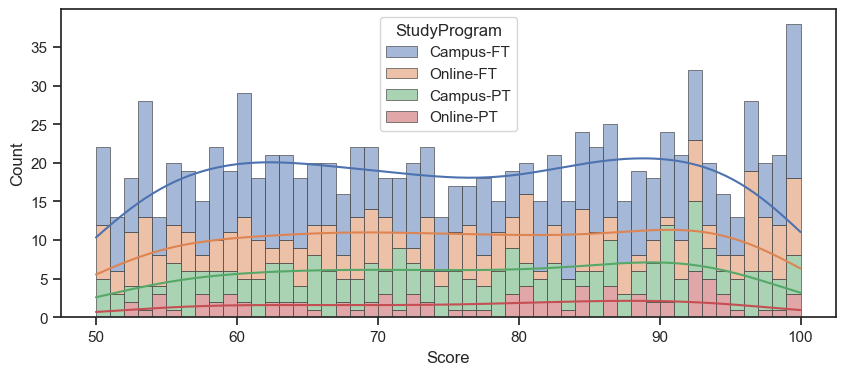

In [873]:
sns.set_theme(style="ticks")
sns.color_palette("PuOr", as_cmap=True)
plt.figure(figsize=(10, 4))

# histogram plot of scores split between different study-programs
sns.histplot(
    data=candidates, x="Score", multiple="stack", 
    hue='StudyProgram',edgecolor=".3", bins=50, linewidth=.5, kde=True
)

From the above histogram, we can observe that the study-mode and study-pattern of a degree don't seem to affect a student's academic performance. This claim is backed up by the similarity in kernel-density line in the histogram above, as regardless of the study-program candidates tend to have a score between 60% and 90%, with some outliers scoring 100%.

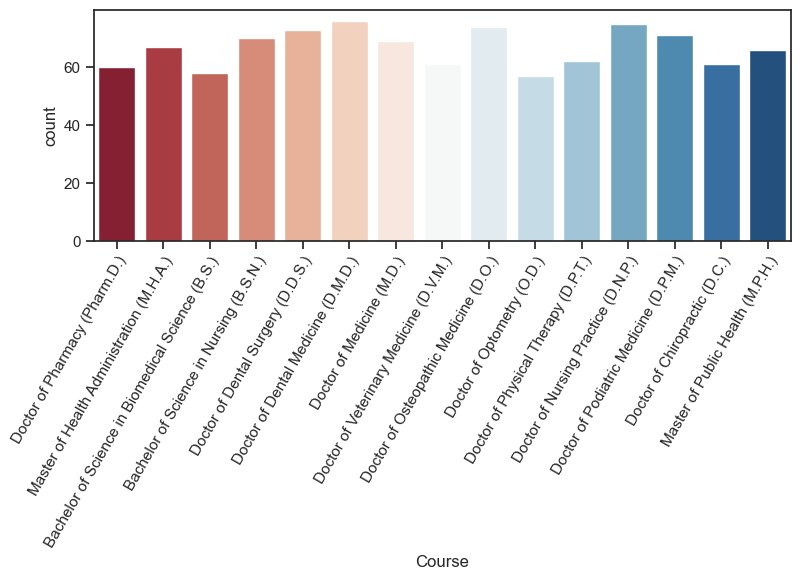

In [874]:
plt.figure(figsize=(9, 3))

# histogram plot of scores split between different study-programs
chart = sns.countplot(data=candidates, x='Course', palette='RdBu', orient="v")

# configure labels along the x-axis
chart.set_xticklabels(chart.get_xticklabels(), rotation=60, ha="right", rotation_mode='anchor')

None # hide the label objects

From the above countplot, we can see that for this particular batch of candidates, the majority are enrolled in Dentistry-related or Nursing/Medicine degree program, which requires that the corresponding batch of jobs must be rich in opportunities for these students, otherwise there's a risk of many of them going unmatched or matched to a less desirable job position

<a id="jobs-data-analysis"></a>
### Jobs Data Analysis

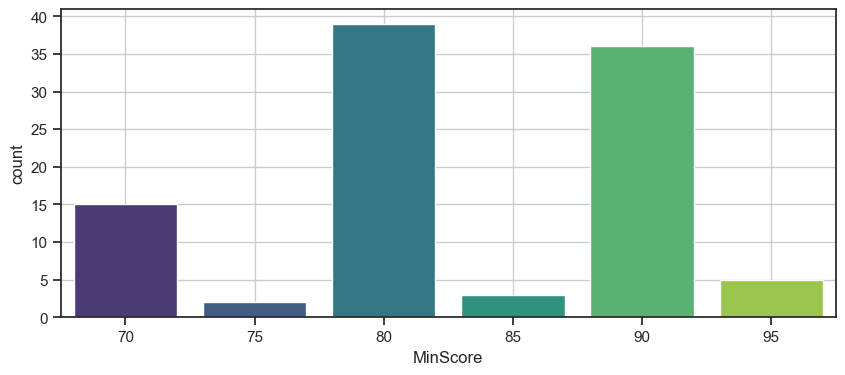

In [875]:
plt.figure(figsize=(10, 4))

# countplot of jobs grouped according to the minimum scored required for their positions
sns.countplot(data=jobs, x='MinScore', palette='viridis', orient="v")

# display the background grid
plt.grid()

From the above countplot, we can observe that most positions require candidates to have a minimum score between 80-90%, with around 12 outliers requiring particularly high score of 95%. 

Comparing this countplot with the one for the student scores, the following can be deduced :
- Any student with a score below 70 risks of not getting matched to any internship
- The students with a score of 100 are likely to be matched to the positions requiring a 95% score. 

It is worth noting that a greedy algorithm might fail to compute a stable match, so for example a student with 100% score might be matched to an internship requiring a 70% instead of a more suitable 95% internship. This would also cause students with a score of 70% having their position stolen from the better students, leaving them potentially unmatched. 

The *Gale-Shapley* algorithm aims to avoid this problem.

In [876]:
# total number of positions per job grouped by field of job
positions_per_field = jobs.groupby("Field").sum(numeric_only=True)["Positions"]

# total number of students with experience grouped by field type
candidates_per_field = candidates["Experience"].value_counts()

supply_demand_df = pd.DataFrame(positions_per_field).join(candidates_per_field)

# create a column to analyse the difference in job supply and demand in each field
supply_demand_df["Supply vs Demand"] = supply_demand_df["Positions"] - supply_demand_df["Experience"]

# show the dataframe
supply_demand_df

,Positions,Experience,Supply vs Demand
Field,,,
dentistry,126,127,-1
immunology,85,147,-62
nursing,115,144,-29
nutrition,177,148,29
physiotherapy,80,156,-76
surgery,107,155,-48


By the above analysis we can conclude that for these particular datasets :

- Physiotherapy has the highest demand to supply ratio, mostly due to the lower number of available job positions in the field
- The remaining fields seem to be abundant in jobs
- If this ratio were to be negative for a field, there's a risk of students remaining unmatched or having to accept a position in a field outside their preferred sector.

Based on these observations alone, and excluding factors such as a job's MinScore vs a student's Score it appears as if *not* every student will be matched to an internship in their field of expertise.

<a id="gale-shapley"></a>
# Gale-Shapley Algorithm
[back to top](#table-of-contents)

The stable matching problem, in its most basic form, takes as input equal numbers of two types of participants (*n* job applicants and *n* employers, for example), and an ordering for each participant giving their preference for whom to be matched to among the participants of the other type. A matching pairs each participant of one type with a participant of the other type. A matching is not stable if:

- There is an element *A* of the first matched set which prefers some given element *B* of the second matched set over the element to which *A* is already matched, and
- *B* also prefers *A* over the element to which *B* is already matched.

In other words, a matching is stable when there is no pair *(A, B)* where both participants prefer each other to their matched partners. If such a pair exists, the matching is not stable, in the sense that the members of this pair would prefer to leave the system and be matched to each other, possibly leaving other participants unmatched. A stable matching always exists, and the algorithmic problem solved by the Gale–Shapley algorithm is to find one.

The Gale–Shapley algorithm involves a number of "rounds" or "iterations". In terms of job applicants and employers, it can be expressed as follows : 

- In each round, one or more employers with open job positions each make a job offer to the applicant they prefer, among the ones they have not yet already made an offer to.
- Each applicant who has received an offer evaluates it against their current position (if they have one). If the applicant is not yet employed, or if they receive an offer from an employer they like better than their current employer, they accept the best new offer and become matched to the new employer (possibly leaving a previous employer with an open position). Otherwise, they reject the new offer.
- This process is repeated until all employers have either filled their positions or exhausted their lists of applicants.

The above algorithm is at the core of the implementation found below, however since the size of the candidates and jobs input sets is most likely to be different, this version of the algorithm only guarantees a portion of the matches computed to be stable, but aims to guarantee that every candidate receives an offer (given that there are enough offers to give out in the first place). 

This section is then concluded by motivating the adoption of an improved version of the algorithm, which takes the same idea of Gale-Shapley and tailors it to this specific problem and then compares both the runtime efficiency and percentage of jobs matched with the data gathered from the basic version.

In [877]:
# return a score to classify the compatibility of a candidate to a job
def compute_compatibility(candidate, job):
    compatibility_score = 0
    
    # check if student has similar experience
    if candidate["Experience"] == job["Field"]: compatibility_score += 1
    else: compatibility_score += 0.5
    
    # assign a reduced factor based on how far off the MinScore the candidate's score is
    candidate_score = candidate["Score"]
    job_minscore = job["MinScore"]
    
    # candidate will prefer job whose MinScore is closer to their achieved grade 
    if candidate_score <= 0.9 * job_minscore or candidate_score >= 1.1 * job_minscore: compatibility_score += 1
    elif candidate_score <= 0.75 * job_minscore or candidate_score >= 1.25 * job_minscore: compatibility_score += 0.5
    else: compatibility_score += 0.25
        
    # account for a candidate preferring location, pay, company title etc.
    compatibility_score += r.random()
    
    return round(compatibility_score, 2)

<a id="benchmark-decorator"></a>
## Performance Benchmark Decorator
[back to top](#table-of-contents)

In [878]:
# decorator function to measure the time performance of function fn
def benchmark(fn):

    @wraps(fn)
    def wrapper(*args, **kwargs):
        
        # save time snapshots before and after function call
        start_time = time()
        result = fn(*args, **kwargs)
        end_time = time()
        
        # display time elapsed and return result of fn call
        print(f'Executed {fn.__name__}, Time Elapsed : {round(end_time - start_time, 3)} seconds')
        return result
    
    # return the wrapper function
    return wrapper 

<a id="control-variables"></a>
## Configuring Control Variables
[back to top](#table-of-contents)

In [879]:
# control variables used by the Gale-Shapley algorithm
total_job_titles = len(jobs)
total_jobs_available = jobs.loc[:total_job_titles, "Positions"].sum()
total_candidates = len(candidates)

In [880]:
# use the tqdm module to implement an real-time progress bar for the loop below
import sys
from time import sleep
from tqdm import trange

# populate the compatibility matrix using the jobs and candidates dataframe
@benchmark
def populate_compatibility_matrix(matrix, candidates, jobs):
    for i in trange(len(candidates), file=sys.stdout, colour='GREEN'):
        for j in range(len(jobs)): 
            matrix.loc[(i, j)] = compute_compatibility(candidates.loc[i], jobs.loc[j])
        sleep(0)

In [881]:
# compute the preference matrix for the given dataframes
def compute_preference_matrix(candidates, jobs):
    
    # use jobs and candidates indices instead of fullname and company as it guarantees uniqueness
    jobs_indices = [ i for i in range(len(jobs)) ]
    candidate_indices = [ i for i in range(len(candidates)) ]

    # create the compatibility dataframe/matrix
    compatibility = pd.DataFrame(0, index=candidate_indices, columns=jobs_indices)
    compatibility = compatibility.rename_axis(index='Candidate IDs', columns='Job IDs')

    # populate the compatibility matrix
    print("Populating the Compatibility matrix...")
    populate_compatibility_matrix(compatibility, candidates, jobs)
    print("Population operation completed.")
    
    return compatibility

In [882]:
# given a list of jobs, return the index of a job with offers to still give out, or -1 if none are found
def find_job(company_ids):
    for i in range(len(company_ids)):
        if company_ids[i] >= 0: return i
    return -1

In [883]:
def suitable_candidates(company_index, compatibility_matrix):
    # retrieve the column with key of company_index from the compatibility matrix
    suit_cands = [(i, compatibility_matrix[company_index][i]) for i in range(len(compatibility_matrix[company_index]))]
    
    # sort the candidates by their compatibility score descending, so company makes offer to most relevant candidates first
    suit_cands.sort(key = lambda x: x[1])
    
    return suit_cands

In [884]:
# display all the offers made in a user-readable format
def format_pairings(offers):
    for candidate_id in offers.keys():
        candidate_name = candidates.loc[candidate_id, "Fullname"]
        job_title = "N/A" if offers[candidate_id][0] == None else jobs.loc[offers[candidate_id][0], "Title"]
        print(f'{candidate_name} -> {job_title}')

In [885]:
@benchmark
# run the gale-shapley algorithm on the input candidates and jobs sets
def gale_shapley(company_ids, offers, compatibility_matrix, available_positions, max_iterations=10000):
    
    # keep track of number of companies fulfilled at each iteration
    fulfillments = []
    iterations = 0
    
    # trigger time-out when algorithm reaches a stagnant point
    while iterations < max_iterations:
        
        # find a company with job offers to give out
        company_id = find_job(company_ids)
        
        # stop condition when all companies have given out jobs
        if company_id == -1: break
            
        # job J with positions still to fill-out
        j = company_ids[company_id]
        
        # find most compatible candidate who company j has not offered a job to yet
        comps = suitable_candidates(j, compatibility_matrix)
        
        # check whether all students reject this company
        all_reject = True
        
        for candidate in comps:
            candidate_id = candidate[0]
            
            # make an offer to this candidate
            if j not in offers[candidate_id][1]:
                
                # check if candidate has no offer yet
                if offers[candidate_id][0] == None:
                    
                    # make the offer 
                    offers[candidate_id][0] = j
                    
                    # change reject status
                    all_reject = False
                    
                    # reduce number of jobs available for job j
                    available_positions[j] -= 1
                    
                    # check number of positions 
                    if available_positions[j] == 0:
                        
                        # all positions have been filled
                        company_ids[j] = -1
                        break
                        
                    # make sure this company cannot make another offer to the same candidate
                    offers[candidate_id][1].append(company_id)
                    break
                    
                else:
                    # make offer, then candidate chooses the company they compare best with
                    k = offers[candidate_id][0] # id of company candidate has an offer from
                    prev_offer_score = compatibility_matrix.loc[candidate_id, k]
                    curr_offer_score = compatibility_matrix.loc[candidate_id, j]
                    
                    if curr_offer_score > prev_offer_score:
                        
                        # candidate accepts new offer 
                        offers[candidate_id][0] = j
                        
                        # change reject status
                        all_reject = False
                        
                        # old offer now becomes free
                        available_positions[k] += 1
                        
                        # current job position is not available to other candidates, so decrement
                        available_positions[j] -= 1
                        
                        # check if old job has new positions free
                        if available_positions[k] == 1: company_ids[k] = k    
                            
                        # check if new job has been completely filled out
                        if available_positions[j] == 0: company_ids[j] = -1  
                            
                    else:
                        # candidate rejects new offer - add this company to the banned list for this candidate
                        offers[candidate_id][1].append(company_id)
                    break
                    
        # if company rejected by all students, then remove it from being considered next
        if all_reject: company_ids[j] = -1
            
        # save number of fulfilled companies after current iteration
        fulfillments.append(company_ids.count(-1))
        iterations += 1
        
    if iterations >= max_iterations: print("Termination due to time-out")
        
    return [offers, fulfillments]

<a id="performance-accuracy"></a> 
## Performance Metrics & Evaluation
[back to top](#table-of-contents)

In [886]:
from time import time

# run the Gale-Shapley algorithm for a range of candidates and jobs
def run_gale_shapley(number_of_candidates, number_of_jobs, verbose):
    
        start_time = time()
        
        print(f"\nRunning Gale-Shapley for {number_of_candidates} candidates and {number_of_jobs} jobs...")
    
        # reduce size of candidates and jobs dataframes 
        candidates_dataframe = candidates.loc[:number_of_candidates]
        jobs_dataframe = jobs.loc[:number_of_jobs]
        
        # compute the compatibility matrix
        compute_matrix_start_time = time()
        compatibility_matrix = compute_preference_matrix(candidates_dataframe, jobs_dataframe)
        compute_matrix_elapsed_time = round(time() - compute_matrix_start_time, 1)
        
        # keeps track of companies with job offers to still give out 
        company_ids = compatibility_matrix.columns.tolist()

        # keeps track of the offers made so far, candidate_id : (current_offer_company_id, [refusing_company_id1, ...])
        offers = { candidate_id : [None, []] for candidate_id in range(number_of_candidates + 1) }

        # keeps track of the number of positions left per job
        available_positions = [ jobs_dataframe.loc[job_id, "Positions"] for job_id in range(len(jobs_dataframe)) ]
        
        # compute the total number of positions across number_of_jobs jobs
        total_jobs = sum(available_positions)
        
        # run the Gale-Shapley algorithm between the jobs and candidates dataset
        offers, fulfillments = gale_shapley(company_ids, offers, compatibility_matrix, available_positions)
        
        if verbose:
            print(f"\nOffers computed for {number_of_candidates} candidates and {number_of_jobs} jobs > ", format_pairings(offers))
        
        # store number of input candidates and input jobs alongside number of matches constructed by gale_shapley
        candidates_with_offers = len([ candidate_id for candidate_id in offers.keys() if offers[candidate_id] != 1 ])
        jobs_assigned = candidates_with_offers
        percentage_metrics = (number_of_candidates, total_jobs, min(candidates_with_offers, number_of_candidates), min(total_jobs, jobs_assigned))
        
        # compute iterations of this algorithm call
        iterations = len(fulfillments)
        
        # compute time of execution
        elapsed_time = round(time() - start_time, 2)
        
        return (fulfillments[::-1], iterations, percentage_metrics, elapsed_time, compute_matrix_elapsed_time)

In [890]:
# compute lineplots for the performance of the algorithm over a range of candidates and jobs
performance_data = [ run_gale_shapley(i, j, verbose=False) for j in range(25, 101, 25) for i in range(100, 1001, 100) ]


Running Gale-Shapley for 100 candidates and 25 jobs...
Populating the Compatibility matrix...
100%|██████████| 101/101 [00:01<00:00, 100.42it/s]
Executed populate_compatibility_matrix, Time Elapsed : 1.022 seconds
Population operation completed.
Executed gale_shapley, Time Elapsed : 0.084 seconds

Running Gale-Shapley for 200 candidates and 25 jobs...
Populating the Compatibility matrix...
100%|██████████| 201/201 [00:02<00:00, 83.93it/s]
Executed populate_compatibility_matrix, Time Elapsed : 2.41 seconds
Population operation completed.
Executed gale_shapley, Time Elapsed : 0.138 seconds

Running Gale-Shapley for 300 candidates and 25 jobs...
Populating the Compatibility matrix...
100%|██████████| 301/301 [00:03<00:00, 87.88it/s] 
Executed populate_compatibility_matrix, Time Elapsed : 3.432 seconds
Population operation completed.
Executed gale_shapley, Time Elapsed : 0.309 seconds

Running Gale-Shapley for 400 candidates and 25 jobs...
Populating the Compatibility matrix...
100%|█████

Executed gale_shapley, Time Elapsed : 2.003 seconds

Running Gale-Shapley for 800 candidates and 75 jobs...
Populating the Compatibility matrix...
100%|██████████| 801/801 [00:21<00:00, 37.44it/s]
Executed populate_compatibility_matrix, Time Elapsed : 21.397 seconds
Population operation completed.
Executed gale_shapley, Time Elapsed : 1.621 seconds

Running Gale-Shapley for 900 candidates and 75 jobs...
Populating the Compatibility matrix...
100%|██████████| 901/901 [00:22<00:00, 39.39it/s]
Executed populate_compatibility_matrix, Time Elapsed : 22.876 seconds
Population operation completed.
Executed gale_shapley, Time Elapsed : 2.061 seconds

Running Gale-Shapley for 1000 candidates and 75 jobs...
Populating the Compatibility matrix...
100%|██████████| 1000/1000 [00:27<00:00, 37.02it/s]
Executed populate_compatibility_matrix, Time Elapsed : 27.016 seconds
Population operation completed.
Executed gale_shapley, Time Elapsed : 2.046 seconds

Running Gale-Shapley for 100 candidates and 100

<a id="jobs-iterations"></a>
### Jobs Remaining vs Iterations

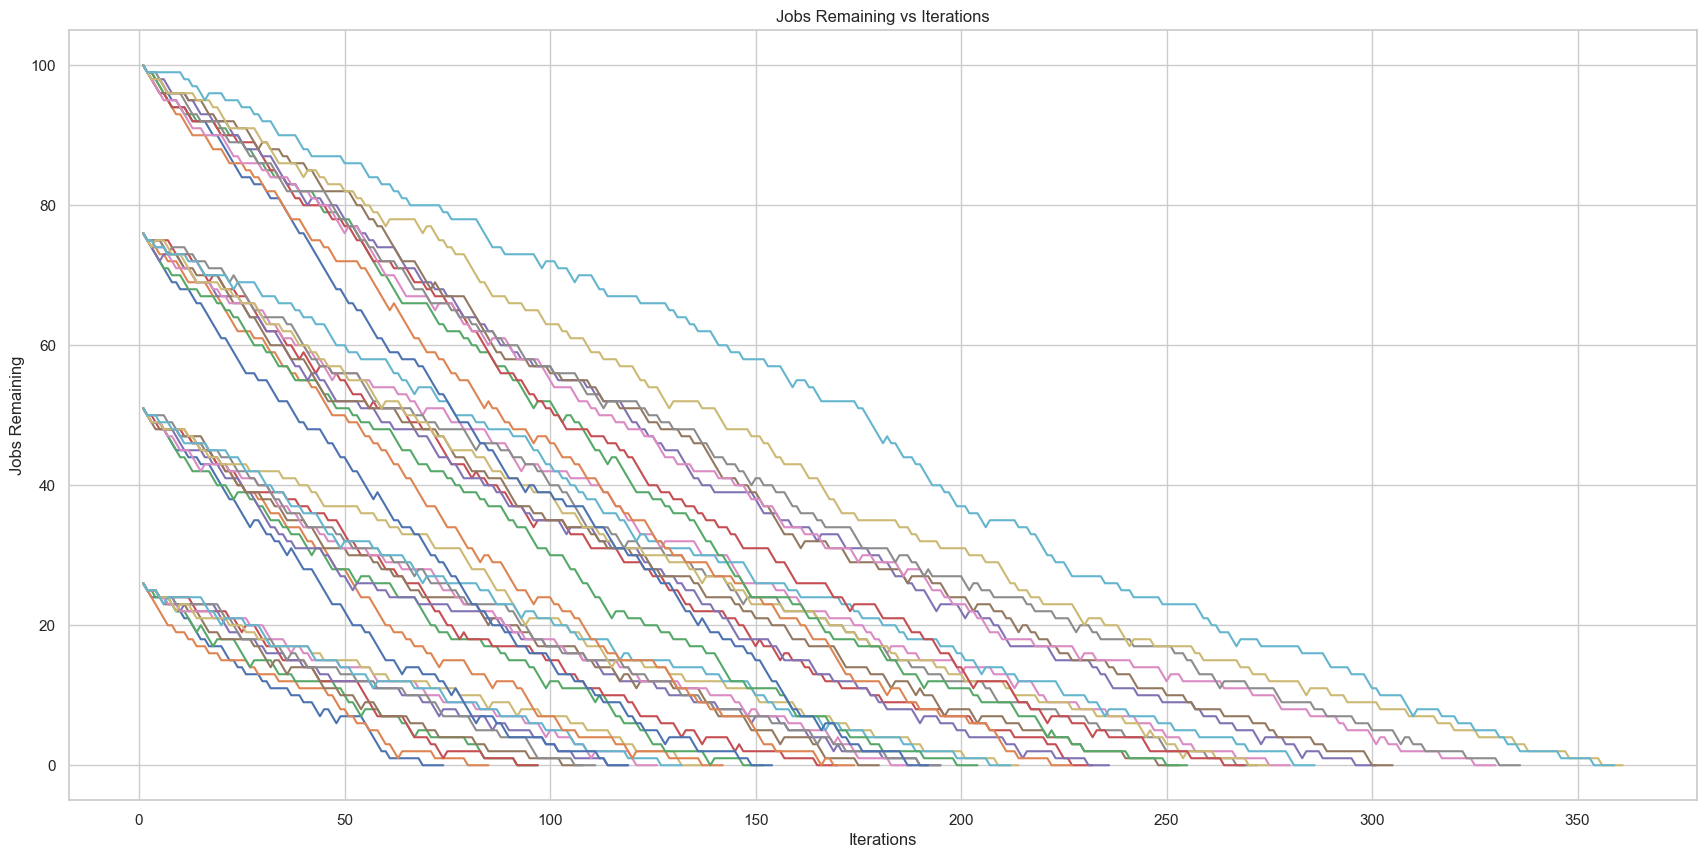

In [891]:
# set the style for the plot
plt.figure(figsize=(21, 10))
sns.set(style="whitegrid")

# configure multi-level index for the dataframe, such that each 100 candidates have 25, 50, 75, 100 jobs 
iterations_outer_index = [ i for i in range(100, 1100, 100) ]
iterations_inner_index = [ i for i in range(25, 125, 25) ]
iterations_multi_index = pd.MultiIndex.from_product([iterations_outer_index, iterations_inner_index], names=['Candidates', 'Jobs Advertised'])

# create a DataFrame with the MultiIndex for the Iterations data
iterations_data = {
    'Iterations' : [ data_tuple[1] for data_tuple in performance_data ],
    'Jobs Remaining' : [ data_tuple[0] for data_tuple in performance_data ],
}

iterations_df = pd.DataFrame(data=iterations_data, index=iterations_multi_index)

for i in range(len(iterations_df)):
    curr_row = iterations_df.iloc[i]
    
    # convert the 'Jobs Remaining' column to a list of lists
    jobs_remaining_list = curr_row['Jobs Remaining']

    # create a DataFrame for the current row
    df_curr_row = pd.DataFrame(
        {'Iterations': range(1, len(jobs_remaining_list) + 1), 
         'Jobs Remaining': jobs_remaining_list}
    )
    
    # create the line plot
    sns.lineplot(data=df_curr_row, x='Iterations', y='Jobs Remaining')
    
# set plot labels and title
plt.title('Jobs Remaining vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Jobs Remaining')
plt.show()

From the above visualization, we can see that the algorithm behaves in a logarithmic way, and in all cases either all jobs are assigned to candidates or all jobs are considered at least once by the algorithm. 

I believe this behaviour is a result of the *all_reject* control variable in the *gale_shapley* methods, as this ensures that if a job position *j* is rejected by all candidates on iteration *x* of the algorithm, then it will be discarded by any future iteration *y*, so *j* has one "pass" of the entire set of candidates to be assigned, otherwise it becomes a reject job.

In conclusion, the use of a single-scan approach to assign job *j* guarantees an extremely fast algorithm [1], however the % of jobs assigned tends to be unacceptably low, as indicated by the chart below titled *Jobs Assigned % per Number of Candidates*, but an optimization can be applied which guarantees 100% matching rate, at the expense of a slight increase in runtime. See the subsection titled *Improving the percentage of jobs assigned* for more details.

[1] In fact most of the computational time of the *run_gale_shapley* driver function is taken up computing the compatibility matrix for the input datasets, so adopting memoization techniques to expand the matrix based on the previous one rather than repopulating it each time would drastically improve the speed of this function

<a id="runtime-inputsize"></a> 
### Run-time vs Input size 

<Figure size 700x400 with 0 Axes>

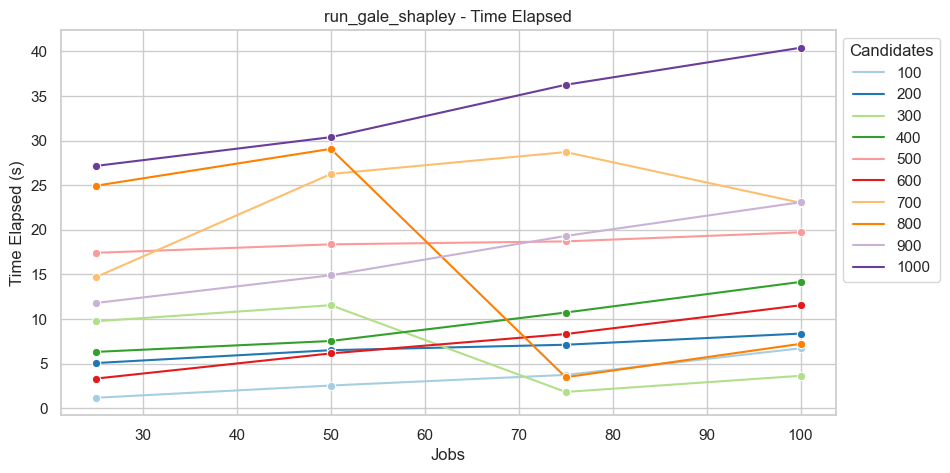

In [892]:
plt.figure(figsize=(7, 4))

time_outer_index = [ i for i in range(100, 1100, 100) ]
time_inner_index = [ i for i in range(25, 125, 25) ]
time_multi_index = pd.MultiIndex.from_product(
    [time_outer_index, time_inner_index], 
    names=['Candidates', 'Jobs Advertised']
)

# create a DataFrame with the MultiIndex for the Time Elapsed data
time_data = {'Time Elapsed' : [ data_tuple[3] for data_tuple in performance_data ] }
time_df = pd.DataFrame(data=time_data, index=time_multi_index)

# plot the above dataframe
sns.set(style="whitegrid")

plt.figure(figsize=(10, 5))
time_chart = sns.lineplot(
    data=time_df.reset_index(), 
    x='Jobs Advertised', 
    y='Time Elapsed', 
    palette='Paired', 
    hue='Candidates', 
    marker='o'
)

plt.title('run_gale_shapley - Time Elapsed')
plt.xlabel('Jobs')
plt.ylabel('Time Elapsed (s)')

sns.move_legend(time_chart, "upper left", bbox_to_anchor=(1, 1))
plt.show()

The above chart suggests that the *run_gale_shapley* method is linear in nature, as the it seems to scale linearly to the increasing number of jobs and is independant of the size of the candidates pool. This makes sense, considering that the underlying algorithm will iterate *n x m* times where *n* is the size of the jobs input set and *m* the size of the candidates set. 

Note however that if *m* approaches *n* the overall time complexity of the algorithm will be *O(n^2)*, but in such case the algorithm would likely terminate before going through *n^2* iterations, since all job offers will be given out before this is the case.

The runtime of this function can be further improved by speeding up the time taken to compute the compatibility matrix and sorting the Series of candidates associated with job *j*, such that the most compatible candidate will be likely to be matched earlier with their 1st choice job position and excluded from the next iteration, as there's no reason for them to give up their current offer for another one guaranteed to be less satisfactory. Formally, if candidate *c* is the one at index 0 in the Series for job *j*, then *compatibility(c) >= compatibility(c')*, where *c'* is at index 1+ so assigning job *j* to *c'* would not benefit neither *c* or *j* and therefore this approach to the pairing problem guaranteed a stable-match [1] in the first generation of the algorithm. [2]

[1] The definition of a stable-match can be found at the top of the Gale-Shapley section.
[2] To better understand the term "generation", please consult the section where I work on improving the time efficiency and accuracy of the algorithm.

<a id="percentage"></a>
### Percentage of Offers vs Input Size

<Figure size 600x400 with 0 Axes>

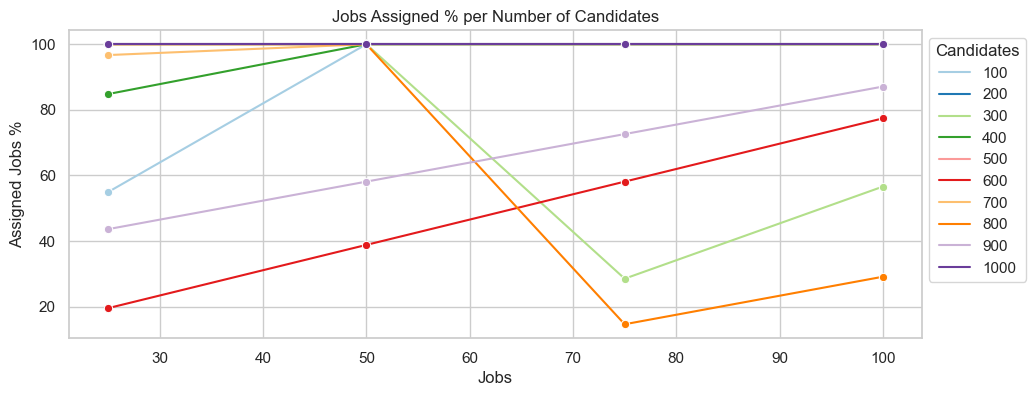

In [893]:
plt.figure(figsize=(6, 4))

# create multi-level index for the dataframe
percentage_outer_index = [ i for i in range(100, 1100, 100) ]
percentage_inner_index = [ i for i in range(25, 125, 25) ]
percentage_multi_index = pd.MultiIndex.from_product(
    [percentage_outer_index, percentage_inner_index], 
    names=['Candidates', 'Jobs Advertised']
)

# create a dataframe with the MultiIndex for the Assignment percentage data
percentage_data = {
    'Assigned Candidates %' : [ round(100 * data_tuple[2][2]/data_tuple[2][0], 1) for data_tuple in performance_data ],
    'Assigned Jobs %' : [ round(100 * data_tuple[2][3]/data_tuple[2][1], 1) for data_tuple in performance_data ]
            }

percentage_df = pd.DataFrame(data=percentage_data, index=percentage_multi_index)

# Plot the above dataframe
sns.set(style="whitegrid")

plt.figure(figsize=(11, 4))
percentage_chart = sns.lineplot(
    data=percentage_df.reset_index(), 
    x='Jobs Advertised', 
    y='Assigned Jobs %', 
    palette='Paired', 
    hue='Candidates', 
    marker='o'
)

plt.title('Jobs Assigned % per Number of Candidates')
plt.xlabel('Jobs')
plt.ylabel('Assigned Jobs %')

sns.move_legend(percentage_chart, "upper left", bbox_to_anchor=(1, 1))
plt.show()

From the above graph, we can conclude that the percentage of jobs assigned to candidates varies drastically between each of the inputs, but an increase in percentage can be observed in all test cases except for input sets of 300 or 800 candidates. This behaviour is most likely to be caused by characteristics specific to the input datasets rather than the decision making within the algorithm. 

Overall it appears as if the percentage of jobs assigned tends to increase as the number of jobs available increases, and this behaviour seems to be consistent regarless of the size of the candidate pool. 

In [894]:
# let's see what the percentage_df indicates about the performance of the algorithm
# percentage_df[percentage_df["Assigned Jobs %"] < 100.0]

<a id="runtime-improvements"></a>
## Run-time Improvements
[back to top](#table-of-contents)

The main aspects this improvement aims to target is to reduce the upfront cost of computing the compatibility matrix by adopting caching techniques and reduce the overall runtime of the matching process. We will explore three different approaches to populating the compatibility matrix for a specific set of inputs and then plot the runtimes to see if caching the previously computed submatrix yields faster execution time.

Reducing the time to compute the matrix can be done by adding rows and columns to a matrix computed for a smaller dataset. For example, the compatibility matrix for an input of 500 candidates and 50 jobs can be computed by populating the compatibility score for the extra 100 candidates against the same 50 jobs instead of re-computing the score for the same 400 candidates again, and then for the 100 new candidates. Note that this approch only improves the time complexity and doesn't affect the space complexity, moreover the time complexity to compute the matrix with the current approach is *O((m x n) ^ 2)* due to the repeated computations, but the amortised time complexity with memoization will be *O(m x n)*, since we are looking up the values from the previous set of inputs in *O(1)* time.

In [895]:
# save the entire dataframes for quick referencing when working with them
candidates_df = candidates
jobs_df = jobs

# define a dataframe to represent the compatibility matrix, whose size can be at most m * n
matrix = pd.DataFrame(
    -1, 
    index=[ i for i in range(len(candidates_df)) ],
    columns=[ j for j in range(len(jobs_df)) ]).rename_axis(index='Candidate IDs', columns='Job IDs')

<a id="compute-matrix-v2"></a>
### Modification - Computing the Compatibility matrix with pre-population assumption

In [896]:
# populate subsection of matrix confined by rows last_row : curr_row and columns last_col : curr_col
def populate_compatibility_matrix_v2(candidates, jobs, matrix, curr_row, last_row, curr_col, last_col):
    for i in range(curr_row - last_row, curr_row):
        for j in range(curr_col - last_col, curr_col):
            matrix.loc[i, j] = compute_compatibility(candidates.loc[i], jobs.loc[j])
    return matrix

In [897]:
# use the previously computed performance data from the run_gale_shapley method
populate_compatibility_matrix_v1_times = [ data_point[4] for data_point in performance_data ]

In [898]:
# test time elapsed to populate matrix section by section, assuming pre-population
populate_compatibility_matrix_v2_times = []
for i in range(100, 1001, 100):
    start_time = time()
    for j in range(25, 101, 25):
        matrix = populate_compatibility_matrix_v2(candidates_df, jobs_df, matrix, i, 100, j, 25)
    elapsed_time = round(time() - start_time, 1)
    populate_compatibility_matrix_v2_times.append(elapsed_time)

In [899]:
populate_compatibility_matrix_v3_times = []
# compute the entire matrix in one scan, computation done beforehand instead of on-demand
start_time = time()
for i in range(len(candidates)):
    for j in range(len(jobs)):
        matrix.loc[i, j] = compute_compatibility(candidates.loc[i], jobs.loc[j])
elapsed_time = round(time() - start_time, 1)

# we append the result of running the entire loop 10 times (100, 200... 1000 candidates) each time, 
# since the inner loop runs in 0.1s on average
for i in range(10):
    populate_compatibility_matrix_v3_times.append(elapsed_time)

<a id="testing-population-methods"></a>
### Testing Matrix Population Methods

In [900]:
# filter times from the performance_data received from the run_gale_shapley method to contain time to compute all jobs per 100 candidates
filtered_populate_compatibility_matrix_v1_times = [ round(sum(populate_compatibility_matrix_v1_times[i : i + 3]),1) for i in range(len(populate_compatibility_matrix_v1_times)) if i % 4 == 0 ]

In [901]:
time_data = {
    'Candidates' : [ i for i in range(100, 1001, 100) ],
    'populator_v1' : filtered_populate_compatibility_matrix_v1_times,
    'populator_v2' : populate_compatibility_matrix_v2_times,
    'populator_v3' : populate_compatibility_matrix_v3_times,
}

# create a dataframe to store the time taken by each approach for x number of candidates 
populate_compatibility_matrix_times_df = pd.DataFrame(time_data)

populate_compatibility_matrix_times_df

,Candidates,populator_v1,populator_v2,populator_v3
0,100,6.9,3.0,39.7
1,200,17.1,2.9,39.7
2,300,20.9,3.0,39.7
3,400,22.8,4.9,39.7
4,500,50.5,3.2,39.7
5,600,17.0,3.6,39.7
6,700,63.4,2.9,39.7
7,800,53.2,3.4,39.7
8,900,43.4,4.1,39.7
9,1000,87.2,4.0,39.7


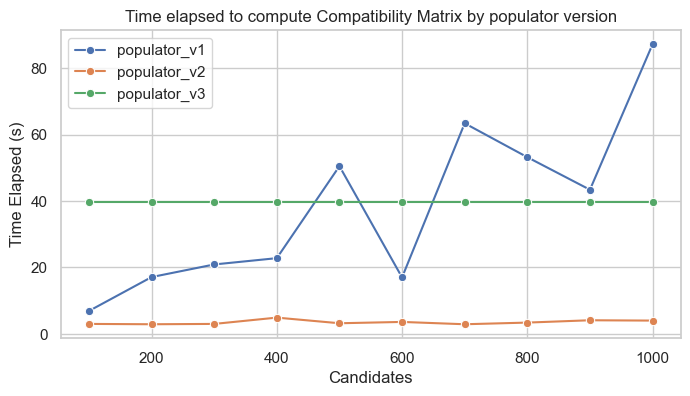

In [902]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))

# plot the lines
sns.lineplot(x='Candidates', y='populator_v1', data=populate_compatibility_matrix_times_df, label='populator_v1', marker='o')
sns.lineplot(x='Candidates', y='populator_v2', data=populate_compatibility_matrix_times_df, label='populator_v2', marker='o')
sns.lineplot(x='Candidates', y='populator_v3', data=populate_compatibility_matrix_times_df, label='populator_v3', marker='o')

# set labels and title
plt.xlabel('Candidates')
plt.ylabel('Time Elapsed (s)')
plt.title('Time elapsed to compute Compatibility Matrix by populator version')

# show the legend
plt.legend()

# show the plot
plt.show()

From the above line plot, we can conclude that the fastest method to compute the Compatibility Matrix for a problem instance is the one outlined by the *populate_compatibility_matrix_v2* method, where for each index input we search for the last populated row index, say *i* and within that row we search for the last populated column index, say *j*.
The slowest approach was the one adopted by the *populate_compatibility_matrix_v1* method, since it re-computes the entire matrix every time a matching query has to be carried out.

In this case, these indices are precisely 100 rows above and 25 columns to the left of each input point, since these are computed by nested for loops with step size of 100 and 25 respectively. **Recall** however, that this method's efficiency only works if the search for *i* or *j* terminates before reaching the beginning of the first row or column, namely indices 0. Otherwise, this approach yields *O(n^2)* complexity since for each index *i* or *j* we search backwards *i* and *j* rows/columns.

To compute the entire matrix ahead, around 35-40 seconds were required. In conclusion, when we are trying to improve the time complexity (notice that the space complexity is the same across all instances, namely *O(m x n)* for *m* candidates and *n* jobs) : 
- If we are trying to populate a subsection of a matrix partially populated, it is slightly more efficient to compute the subsection based on the assumption that the previous subsection has been populated
- If we have a lot of matching queries to execute and the maximum number of candidates and jobs is known in advance, compute the entire matrix in *O(m x n)* time and access the compatibility values in *O(1)*

<a id="improving-offer-pecentage"></a>
## Improving the percentage of offers computed 

Except for some edge cases, the percentage of jobs fully exhausted (i.e. all of its positions are filled) is usually less than 100%. This might be due to several factors, such as a particular job being "banned" from a succeeding iteration of the algorithm if no candidate was willing to accept the offer made during the current round. 

An approach which could be used to maximize the percentage of jobs assigned relies on one simple concept, for us humans at least, which is that a candidate in a competitive pool would much rather have an offer from a company which was not their first choice rather than end up with no offers at the end of the recruitment cycle due to their preferences. 

In the scope of the Gale-Shapley algorithm, this concept would be implemented through simple modifications.

1. The *compute_compatibility(candidate, job)* function will now take in a 3rd parameter *alpha* which denotes how many attributes are included in the computation of the score. For example is *alpha* = 0, then all attributes are involved and if *alpha* = n (number of attributes) then the score output defaults to 0.0

2. The *run_gale_shapley(...)* function will now do the following : 
    - set *alpha* to 0
    - execute Gale-Shapley on the input sets
    - exclude the candidates and jobs members of an offer from the input sets
    - increase *alpha* by 1 
    - repeat Gale-Shapley on this filtered data set until either input set is empty (i.e. jobs = None or candidates = None).
    
With these modifications in place, a 100% offer-rate is guaranteed, since the compatibility scores of each (candidate, job) pair will eventually converge to 0.0 and the algorithm will assign the remaining entites on a first-come, first-serve basis until the stopping condition is met.

Note however, that candidates and jobs matched in round *i* are more likely to be satisfied with their pairing than two entites matched in round *i+1* since their compatibility score is likely to be close to the one of other entities in the same input sets.

<a id="gale-shapley-conclusion"></a>
## Conclusion
[back to top](#table-of-contents)

In conclusion, the variant of the Gale-Shapley algorithm implemented in this subsection is a reliable approach to automating the matchmaking process between a set of candidates to a set of job offers. The main advantage of using this offline pairing strategy is that a stable match is guaranteed between the two input sets, with candidates left without an offer being the least qualified for the entire pool of available jobs since by nature, the algorithm will compare the current job it is trying to assign to the offer held by the candidate it is currently considering and assign them the job with maximal compatibility score.

<a id="classification-df-setup"></a> <br>
# Constructing the Dataframe for the Classification Tasks

In [903]:
# populate the candidates and jobs dataframes with more columns to infere numerical features later on
candidates["Contract length"] = np.nan
candidates["Expected Salary"] = np.nan
candidates["Location"] = np.nan

jobs["Contract length"] = np.nan
jobs["Salary"] = np.nan
jobs["Location"] = np.nan

In [904]:
# random uk towns 
uk_locations = ["London","Edinburgh","Manchester","Bristol","Birmingham","Glasgow","Liverpool","Cardiff","Belfast","Newcastle"] 

In [905]:
# add candidate's visa status, salary expectation, location (city), wanted contract length (3, 6, 9, 12 months)
for i in range(len(candidates)):
    candidates.at[i, "Contract length"] = r.choice([3,6,9,12])
    candidates.at[i, "Expected Salary"] = r.choice([15000, 17500, 20000, 22500, 25000, 27500, 30000])
    candidates.at[i, "Location"] = r.choice(uk_locations)

# add job's salary, contract length (3, 6, 9, 12 months), location (city)
for i in range(len(jobs)):
    jobs.at[i, "Contract length"] = r.choice([3,6,9,12]) 
    jobs.at[i, "Salary"] = r.choice([15000, 17500, 20000, 22500, 25000, 27500, 30000])
    jobs.at[i, "Location"] = r.choice(uk_locations)

In [906]:
# check out the head of the new candidates dataframe
candidates.head()

,Fullname,Course,Score,Experience,StudyProgram,Contract length,Expected Salary,Location
0,Ashley Harris,Doctor of Pharmacy (Pharm.D.),96,nutrition,Campus-FT,12.0,17500.0,London
1,Maria Harris,Master of Health Administration (M.H.A.),77,surgery,Campus-FT,9.0,15000.0,Manchester
2,Thomas Boyer,Bachelor of Science in Biomedical Science (B.S.),86,immunology,Online-FT,6.0,25000.0,Birmingham
3,Holly Friedman,Bachelor of Science in Nursing (B.S.N.),82,physiotherapy,Online-FT,9.0,22500.0,Edinburgh
4,Rebecca Cook DVM,Doctor of Pharmacy (Pharm.D.),63,nursing,Campus-FT,3.0,22500.0,Edinburgh


In [907]:
# checkout the new head of the refined jobs dataframe
jobs.head()

,Title,Company,Field,MinScore,Positions,Contract length,Salary,Location
0,Dental Hygienist Internship,"Jimenez, Carney and Foley",physiotherapy,80,7,9.0,17500.0,Manchester
1,Registered Nurse Placement,"Roth, Rose and Cross",nutrition,80,8,12.0,27500.0,Belfast
2,Dental Hygienist Internship,Russell-Banks,nutrition,90,10,9.0,22500.0,Glasgow
3,Dental Hygienist Internship,Martin Ltd,immunology,80,3,6.0,22500.0,Glasgow
4,Physician Internship,Lambert Group,nutrition,80,9,6.0,22500.0,Glasgow


In [908]:
# define the functions used to infere numerical features in the cell below
def compute_field_xp_relevance(candidate_experience, job_experience):
    return 1 if candidate_experience == job_experience else 0

def compute_contract_length_compatibility(candidateID, jobID):
    diff = candidates.iloc[candidateID]["Contract length"] - jobs.iloc[jobID]["Contract length"]
    return diff//3

def compute_location_compatibility(candidateID, jobID):
    # return a random number between 0 and 500km for now, 
    # a future improvement will be to calculate the distance between the candidate's city and the job's city
    return r.randint(0, 500)

def compute_visa_requirements(candidateID, jobID):
    distance = compute_location_compatibility(candidateID, jobID)
    # if candidate is applying for a job 400+ km away they are more likely to be outside the UK
    return 1 if distance > 400 else 0 

def compute_offer_outcome(gpa_diff, field_xp_relevance, contract_compatibility, location_compatibility, visa_required, salary_diff):
    offer_score = 0
    
    offer_score += 1 if gpa_diff < 20 else 0
    offer_score += contract_compatibility
    offer_score += 1 if location_compatibility < 400 else 0
    offer_score += 0 if visa_required else 1
    offer_score += 1 if salary_diff < 4000 else 0
    
    return 1 if offer_score >= 3.0 else 0

In [909]:
# generate the data which will be underlying the dataframe used for classification
df_data = []

# populate the table with 500 offers alongside their outcomes 
for i in range(0, len(candidates)):

    # get random candidate and jobs entries and their respective IDs
    candidateID, jobID = i, r.randint(0, len(jobs)-1)
    candidate, job = candidates.iloc[candidateID], jobs.iloc[jobID]
    
    # extract the candidate gpa and job's minimum gpa required
    candidate_gpa, job_gpa = candidates.iloc[candidateID]["Score"], jobs.iloc[jobID]["MinScore"]

    # compute the compatibility score between the two selected entities
    alpha_score = compute_compatibility(candidate, job)
    
    gpa_diff = candidate_gpa - job_gpa
    field_xp_relevance = compute_field_xp_relevance(candidates.iloc[candidateID]["Experience"], jobs.iloc[jobID]["Field"])
    contract_compatibility = compute_contract_length_compatibility(candidateID, jobID)
    location_compatibility = compute_location_compatibility(candidateID, jobID)
    visa_required = compute_visa_requirements(candidateID, jobID)
    salary_diff = jobs.iloc[jobID]["Salary"] - candidates.iloc[candidateID]["Expected Salary"]
    
    offer_outcome = compute_offer_outcome(
        gpa_diff, field_xp_relevance, contract_compatibility, location_compatibility, visa_required, salary_diff
    )
    
    row = [ candidateID, jobID, candidate_gpa, job_gpa, alpha_score, gpa_diff, field_xp_relevance, contract_compatibility, location_compatibility, visa_required,salary_diff, offer_outcome, ]
    df_data.append(row)

In [910]:
df_cols = [
    'candidate ID', 'job ID', 'candidate GPA', 'job min GPA', 'compatibility', 'gpa_diff', 
    'field-xp relevance', # relevance score for the candidate's experience vs the job's field
    'contract length compatibility', # candidate's preferred contract length vs job contract length
    'location compatibility', # distance from candidate's location vs location of the job
    'visa sponsorship required', # yes/no to whether candidate requires visa sponsorship for the job
    'salary expectation-paid diff', # difference of salary expectation for candidate vs job salary
    'accepted offer'
]

df = pd.DataFrame(data=df_data, columns=df_cols)
df

,candidate ID,job ID,candidate GPA,job min GPA,compatibility,gpa_diff,field-xp relevance,contract length compatibility,location compatibility,visa sponsorship required,salary expectation-paid diff,accepted offer
0,0,17,96,90,1.25,6,0,0.0,263,0,-2500.0,1
1,1,13,77,90,1.81,-13,0,0.0,344,1,2500.0,1
2,2,80,86,80,0.97,6,0,-1.0,183,1,-7500.0,0
3,3,43,82,90,1.16,-8,0,-1.0,200,0,5000.0,0
4,4,44,63,90,2.28,-27,0,-3.0,312,1,-2500.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,19,72,80,2.29,-8,0,0.0,246,0,5000.0,1
996,996,46,71,80,2.09,-9,0,-1.0,99,0,5000.0,0
997,997,18,92,90,2.20,2,1,-3.0,102,0,10000.0,0
998,998,27,86,80,0.87,6,0,0.0,283,0,2500.0,1


In [911]:
df = df.drop(['candidate ID', 'job ID'], axis=1)
df

,candidate GPA,job min GPA,compatibility,gpa_diff,field-xp relevance,contract length compatibility,location compatibility,visa sponsorship required,salary expectation-paid diff,accepted offer
0,96,90,1.25,6,0,0.0,263,0,-2500.0,1
1,77,90,1.81,-13,0,0.0,344,1,2500.0,1
2,86,80,0.97,6,0,-1.0,183,1,-7500.0,0
3,82,90,1.16,-8,0,-1.0,200,0,5000.0,0
4,63,90,2.28,-27,0,-3.0,312,1,-2500.0,0
...,...,...,...,...,...,...,...,...,...,...
995,72,80,2.29,-8,0,0.0,246,0,5000.0,1
996,71,80,2.09,-9,0,-1.0,99,0,5000.0,0
997,92,90,2.20,2,1,-3.0,102,0,10000.0,0
998,86,80,0.87,6,0,0.0,283,0,2500.0,1


<a id="linear-svm"></a> <br>
# Linear Support Vector Machines
[back to top](#table-of-contents)

A support vector machine (SVM) is a machine learning algorithm that uses supervised learning models to solve complex classification, regression, and outlier detection problems by performing optimal data transformations that determine boundaries between data points based on predefined classes, labels, or outputs.

It aims to do binary classification of data by finding a hyperplane that best fits the data points in a continuous space, instead of fitting a line to the data points. It essentially partitions this continous space in two classes, such that similar data points cluster together and end up on the same side of the hyperplane.

<a id="svm-strategy"></a> <br>
### Proposed Strategy for the SVM model

- The task at hand is to create a model capable of predicting whether an offer between a candidate and a job is likely to be accepted by the candidates involved. If the SVM classifier redeems the offer as likely to be accepted, then it will select it for further operations, otherwise a rejection will happen.

- Each entry in the training dataframe will have the following (or similar) format : 

| Candidate ID | Job ID      | Candidate GPA | Job Minimum GPA | Compatibility Score | ...          | Offer Accepted |
| -----------  | ----------- | -----------   | -----------     | -----------         | -----------  | -----------    |
| 58           | 22          | 78            | 63              | 2.3                 | ...          | YES            |
| 29           | 68          | 66            | 80              | 1.6                 | ...          | NO             |

- The model will then classify an incoming offer based on the numerical features from the dataframe, such as GPAs and Compatibility score and label the offer as "accepted" or "rejected"

<a id="svm-data-analysis"></a> <br>
### Exploratory Data Analysis 

In this subsection, I will generate a plot of the three main features I plan on using to develop a Support Vector Classifier : the candidate's score (or GPA), the job's minimum score required, and the compatibility score of the candidate and job based on non-numerical attributes, named *alpha*.
In addition, I will plot a heatmap of the compatibility matrix generated for a particular input set to see if there are any patterns hidden within which could help gather insight while developing the SVC.

In [965]:
# trim the candidates and jobs dataset for plotting purposes 
svm_candidates = candidates.iloc[:25]
svm_jobs = jobs[:25]

# compute preference matrix for the initial candidates and jobs input sets, after data cleaning
matrix = compute_preference_matrix(svm_candidates, svm_jobs)

Populating the Compatibility matrix...
100%|██████████| 25/25 [00:00<00:00, 32.98it/s]
Executed populate_compatibility_matrix, Time Elapsed : 0.831 seconds
Population operation completed.


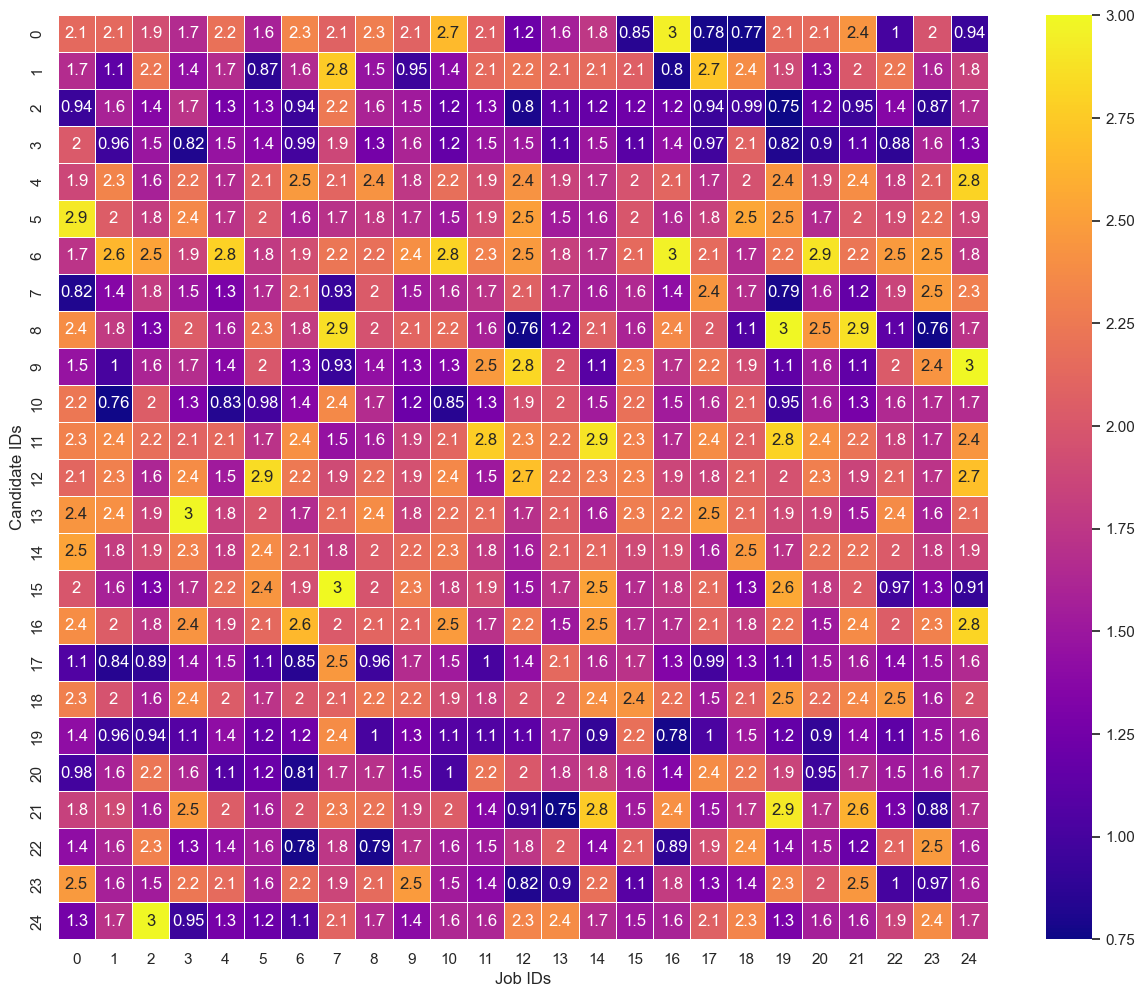

In [966]:
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(matrix, cmap="plasma", annot=True, linewidth=.5)
plt.show()

From the heatmap above, it is clear that for the subset of jobs and candidates selected, the compatibility score tends to be between the 2.50 and 1.50, with outlier pairs looking to be evenly spread between the extremes of the color scale. This was expected, considering that the data in the candidates and jobs dataframe was randomly generated, however this plot makes me believe that most of the matches computed will not be stable (click [**here**](#gale-shapley) for a refresher) but that is expected since most matches computed in a dynamic environment like the real world tend to follow this pattern.

While this heatmap is informative, plotting the features involved in three dimensions might help us deduce more information about the dataset.

In [967]:
matrix = np.zeros((100, 10))

# populate matrix with compatibility score
for i in range(100):
    for j in range(10):
        matrix[i, j] = compute_compatibility(candidates.loc[i], jobs.loc[j])

x_indices = np.arange(matrix.shape[0])
y_indices = np.arange(matrix.shape[1])
X, Y = np.meshgrid(x_indices, y_indices)

fig = go.Figure(data=[go.Scatter3d(
    x=X.flatten(), y=Y.flatten(), z=matrix.flatten(), 
    mode='markers', marker=dict(size=5,color=matrix.flatten(), colorscale='Plasma',  opacity=0.8)
)])

fig.update_layout(
    title='Candidate ID vs Job ID vs Compatibility', 
    scene=dict(xaxis_title='Candidate ID', yaxis_title='Job ID', zaxis_title='Compatibility'),
    autosize=False, width=700, height=700, margin=dict(l=65, r=50, b=65, t=90)
)

# plot the green plane to distinguish the top 34-66% of compatibility scores
x_range = np.linspace(X.min(), X.max(), num=2)
y_range = np.linspace(Y.min(), Y.max(), num=2)
xx, yy = np.meshgrid(x_range, y_range)
zz = np.full(xx.shape, 1.4)
fig.add_trace(go.Surface(x=xx, y=yy, z=zz, colorscale=[[0, 'rgba(0, 204, 102, 0.4)'], [1, 'rgba(0, 204, 102, 0.6)']], showscale=False))

# plot the blue plane to separate the bottom 33% of compatibility scores
x_range = np.linspace(X.min(), X.max(), num=2)
y_range = np.linspace(Y.min(), Y.max(), num=2)
xx, yy = np.meshgrid(x_range, y_range)
zz = np.full(xx.shape, 2.5) 
fig.add_trace(go.Surface(x=xx, y=yy, z=zz, colorscale=[[0, 'rgba(0, 153, 255, 0.4)'], [1, 'rgba(0, 153, 255, 0.6)']], showscale=False))

fig.show()

From the above 3D scatterplot, we can observe that most of the compatibility scores for this set of inputs score between 1.5 and 2.5 *green-blue plane*, with outliers being found in the bottom 30% for the vast majority and a smaller portion (about 16%) found in the 2.5-3 band. This plot indicates that most of the matches computed will not be [**stable**](#gale-shapley) since the compatibility score tend to be distributed towards the lower end of the 0.0 to 3.0 range of possible values.

<a id="svm-implementation"></a> <br>
### Implementing the SVM classifier

In [968]:
# split the dataframe's features into ones that will be used for training (X) and what feature we are trying to 
# carry out the classification task on (y)
X = df.drop(['accepted offer'], axis=1)
y = df['accepted offer']

# split the datasets into 70% training data and 30% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [969]:
# train and test the svm classifier
model = SVC(kernel="linear")
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [970]:
# display the confusion matrix and classfication report for this model
print(confusion_matrix(y_test, predictions))
print('\n')
print(classification_report(y_test, predictions))

[[ 95  15]
 [  9 181]]


              precision    recall  f1-score   support

           0       0.91      0.86      0.89       110
           1       0.92      0.95      0.94       190

    accuracy                           0.92       300
   macro avg       0.92      0.91      0.91       300
weighted avg       0.92      0.92      0.92       300



<a id="svm-improvement"></a> <br>
### Improving the Precision of the SVM classifier

In this subsection, we carry out a grid search to find the combination of hyper-parameters passed into the above SVC classifier which yield the best output.

- **Kernel** : The main function of the kernel is to transform the dataset input data into a required form by extrapolating information from existing data and then lead to better classification. More in the [**evaluation**](#svm-evaluation) section.

- **Regularization** : Regularization is implemented via the *C* parameter in the model, and it is used by the SVC as a guide on how much misclassification error is tolerated and controls the trade-off between decision boundary and misclassification term. A smaller value of C creates a small-margin hyperplane and a larger value of C creates a larger-margin hyperplane.

- **Gamma** : A lower value of gamma will loosely fit the training dataset, whereas a higher value of gamma will exactly fit the training dataset, which causes over-fitting. In other words, a low value of gamma considers only nearby points in calculating the separation line, while a higher value of gamma considers all the data points in the calculation of the separation line.

In [971]:
# define parameter values range for the SVC classifier
param_grid = { 'C' : [0.1, 1, 10, 100, 1000, 10000, 100000], 'gamma' : [1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001] }

In [972]:
# perform a GridSearch to find the best combination of C and gamma values for the SVC classifier
# the higher the "verbose" parameter, the more textual output will be displayed once the GridSearch executes
grid = GridSearchCV(SVC(), param_grid, verbose=1)

In [973]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000, 10000, 100000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06]},
             verbose=1)

In [974]:
# display the hyper-parameters which yield the SVM classifier with the best 'score' accoring to GridSearch
grid.best_params_

{'C': 100000, 'gamma': 1e-06}

In [975]:
# display an instance of the SVC with optimal hyper-parameters
grid.best_estimator_

SVC(C=100000, gamma=1e-06)

In [976]:
# train the SVM classifier again using the optimal hyperparameters from the GridSearch
grid_predictions = grid.predict(X_test)

In [977]:
print(confusion_matrix(y_test, grid_predictions))
print('\n')
print(classification_report(y_test, grid_predictions))

[[ 87  23]
 [  8 182]]


              precision    recall  f1-score   support

           0       0.92      0.79      0.85       110
           1       0.89      0.96      0.92       190

    accuracy                           0.90       300
   macro avg       0.90      0.87      0.89       300
weighted avg       0.90      0.90      0.89       300



<a id="svm-evaluation"></a> <br>
### Evaluation of the SVM classifier 

In conclusion, the SVM classifier trained in this section yielded an acceptable 90-95% precision score when classifying offers as "likely to be accepted" or "likely to be rejected". This score has been achieved by first carrying out a SVM classification with default parameters and no kernel, and then improved by experimenting with different kernel functions and C-gamma hyper-parameter combinations.

**Noticeable observations** include:

1. Initially the model has been trained on a dataframe with 3 numerical columns which yielded a precision of 31%, but when training the model on 8 numerical columns a score of 65% was obtained. 
2. Without setting a kernel function in the SVC() instance but carrying out a grid-search with the C-gamma hyperparameters, the previous percentage reached values of 83%. 
3. Finally, experimenting with different kernel functions allowed the model to reach a precision of 92%, obtained through a Linear kernel function. Interestingly, using the Sigmoid or Polynomial kernel function lead to a significant decrease in the precision percentage of around 35-40%.
4. Experimenting with different training/test splits of the input dataframe, 70/30 seemed to yield the best results.

While the outputs of the confusion matrix and classification reports are very promising, I believe more training needs to carried out to deploy this model for real-world classification. The two main issues I identified where : 

1. Size of the input training dataset - the limited size of the input set (1000 candidates and 700-800 jobs) means that the model is trained on a very specific set of values for each feature, which might lead to an under-performing (overfitted) model in a real-world scenario. 
2. Quality of the input training dataset - since the original *candidates* and *jobs* dataframes contain randomly generated data, there is minimal correlation between datapoints so it is more challenging to do inference on the data.  

<a id="knn-algorithm"></a> <br>
# K-Nearest Neighbours Algorithm
[back to top](#table-of-contents)

KNN is a classification algorithm that operates on the principle that similar data points tend to cluster around certain values of specific numerical features. 

KNN tries to predict the correct class for the test data by calculating the distance between the test data and all the training points. Then select the K number of points which is closet to the test data. The KNN algorithm calculates the probability of the test data belonging to the classes of ‘K’ training data and class holds the highest probability will be selected.

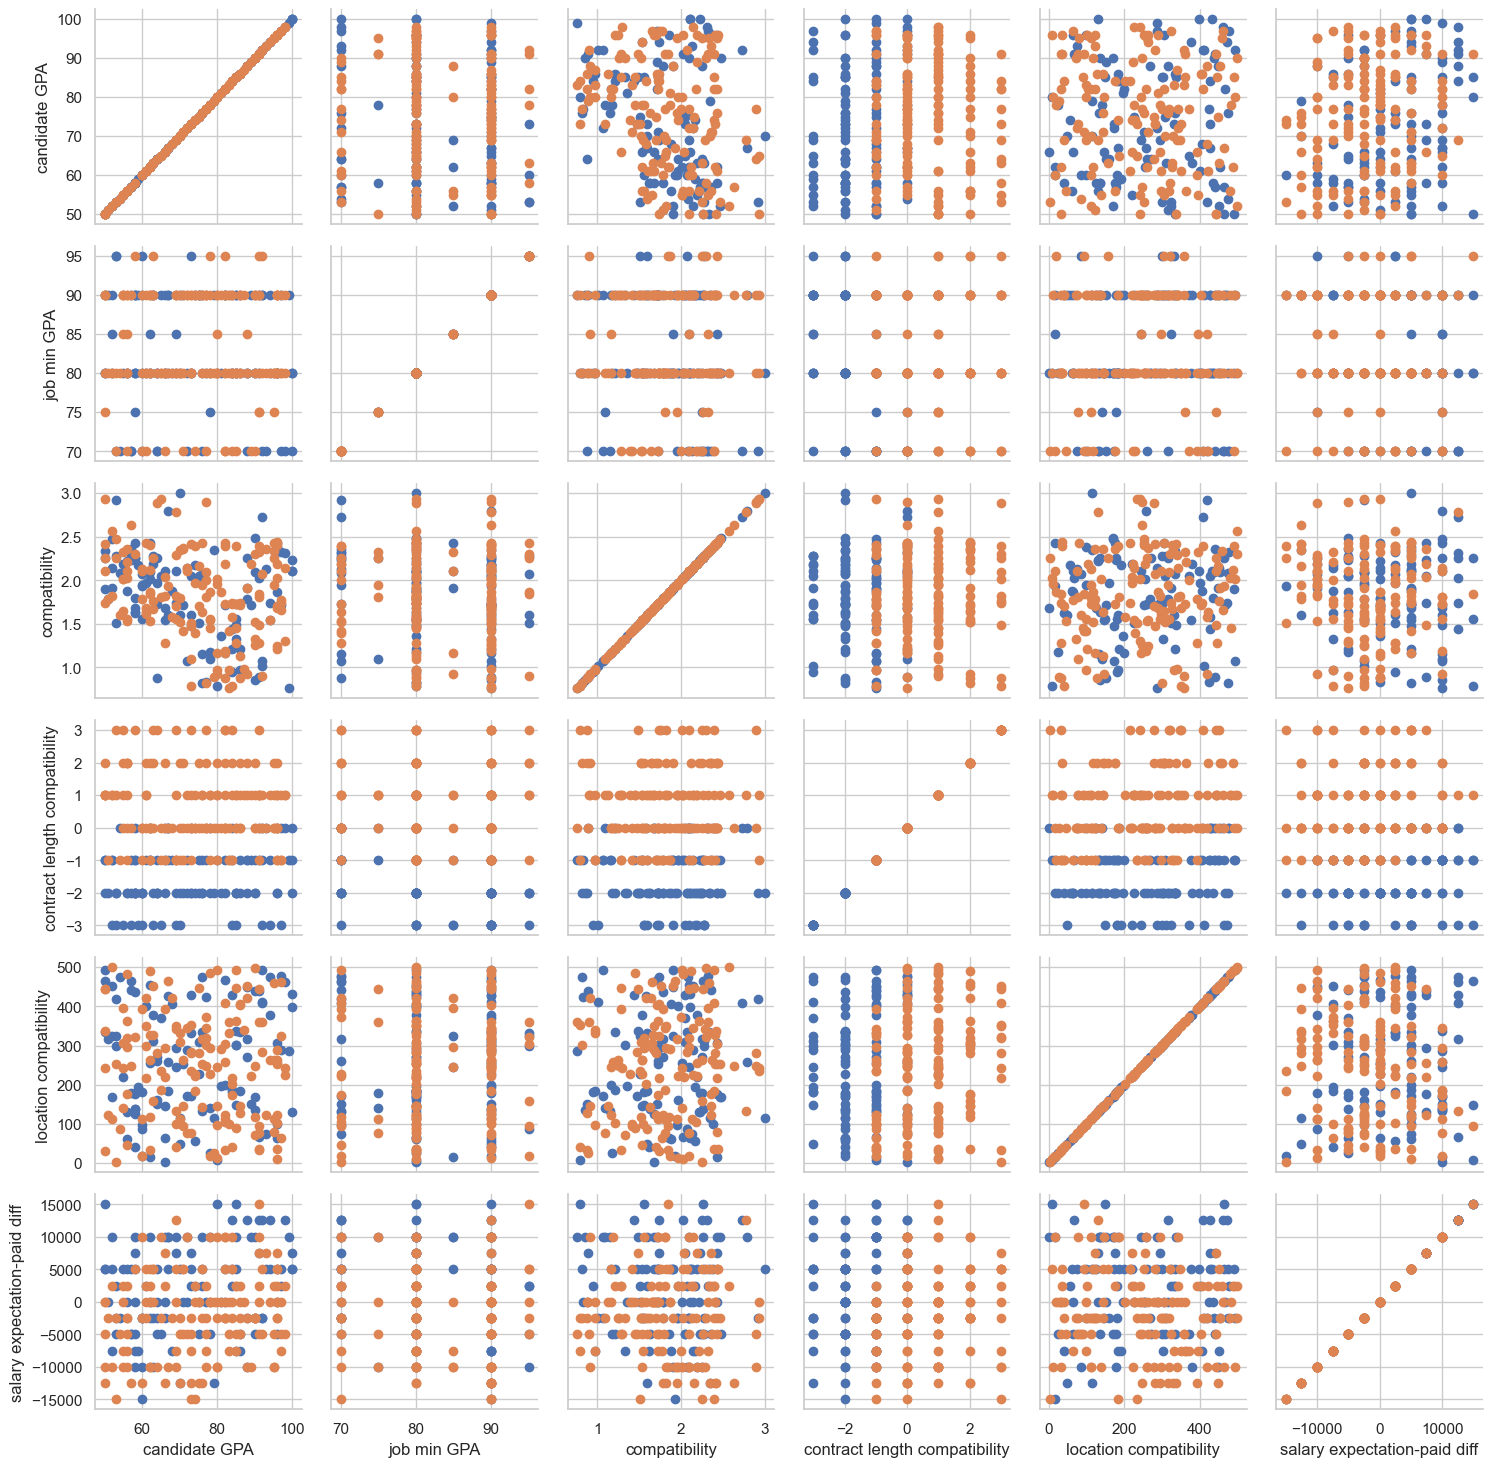

In [978]:
# reduce size of dataframe for computational performance reasons
knn_df = df.drop(['gpa_diff', 'field-xp relevance', 'visa sponsorship required'], axis=1)[:250]

# carry out a pair-plot of all the features in the dataframe to hopefully spot correlation between pairs of variables
knn_gridplot = sns.PairGrid(knn_df, hue='accepted offer')
knn_gridplot.map(plt.scatter)

<a id="knn-data-scaling"></a> <br>
### Standardizing the data for classification

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data.

For instance many elements used in the objective function of a learning algorithm assume that all features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

StandardScaler is sensitive to outliers, and the features may scale differently from each other in the presence of outliers. In conclusion, since outliers have a much greater influence on the classification task during the training phase, it is crucial to scale them properly to avoid an ill-defined model.

In [979]:
scaler = StandardScaler()

In [980]:
knn_df = df.drop(['gpa_diff', 'field-xp relevance', 'visa sponsorship required'], axis=1)
scaler.fit(knn_df.drop('accepted offer', axis=1))

StandardScaler()

In [981]:
acc_offers = scaler.transform(knn_df.drop('accepted offer', axis=1))

In [982]:
acc_offers

array([[ 1.39662918,  0.94367778, -1.20053087,  0.10204848,  0.12521094,
        -0.27437717],
       [ 0.1165542 ,  0.94367778, -0.05839186,  0.10204848,  0.6892869 ,
         0.44766802],
       [ 0.72290551, -0.40539696, -1.77160038, -0.531793  , -0.43190113,
        -0.99642236],
       ...,
       [ 1.12713971,  0.94367778,  0.73702639, -1.79947597, -0.9959771 ,
         1.5307358 ],
       [ 0.72290551, -0.40539696, -1.97555378,  0.10204848,  0.26448895,
         0.44766802],
       [-0.15293527,  0.94367778,  0.79821241,  0.73588996, -1.23274972,
         0.08664542]])

In [983]:
# create an auxiliary dataframe which mirrors the orginal one, except its values are scaled for classification
knn_df_feat = pd.DataFrame(acc_offers, columns=knn_df.columns[:-1])

In [984]:
knn_df_feat.head()

,candidate GPA,job min GPA,compatibility,contract length compatibility,location compatibility,salary expectation-paid diff
0,1.396629,0.943678,-1.200531,0.102048,0.125211,-0.274377
1,0.116554,0.943678,-0.058392,0.102048,0.689287,0.447668
2,0.722906,-0.405397,-1.771600,-0.531793,-0.431901,-0.996422
3,0.453416,0.943678,-1.384089,-0.531793,-0.313515,0.808691
4,-0.826659,0.943678,0.900189,-1.799476,0.466442,-0.274377


In [985]:
# split the dataframe's features into ones that will be used for training (X) and what feature we are trying to 
# carry out the classification task on (y)
X = knn_df_feat
y = knn_df['accepted offer']

# split the datasets into 70% training data and 30% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [986]:
# initialise a KNN classifier which computes the error rate between a centroid and 1 of its neighbours
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)

In [987]:
# display the confusion matrix and classfication report for this model
print(confusion_matrix(y_test, predictions))
print('\n')
print(classification_report(y_test, predictions))

[[ 85  25]
 [ 20 170]]


              precision    recall  f1-score   support

           0       0.81      0.77      0.79       110
           1       0.87      0.89      0.88       190

    accuracy                           0.85       300
   macro avg       0.84      0.83      0.84       300
weighted avg       0.85      0.85      0.85       300



<a id="knn-elbow-method"></a> <br>
### Improving KNN using The Elbow Method

The elbow method is an optimisation technique used in KNN to find the optimal number of neighbours 'K' such that the error rate is minimized, or increasing 'K' does not yield a significant increase in accuracy of classification.

We do this by iterating through 'n' models and keeping track of the error rate for a model at each iteration, then we select the model with minimal error for training and testing, and hopefully observe an improvement from the previous ones.

In [988]:
error_rate = []

for i in range(1, 50):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    predictions_i = knn.predict(X_test)
    # average error rate, where predicitons where not equal to actual test values 
    error_rate.append(np.mean(predictions_i != y_test))

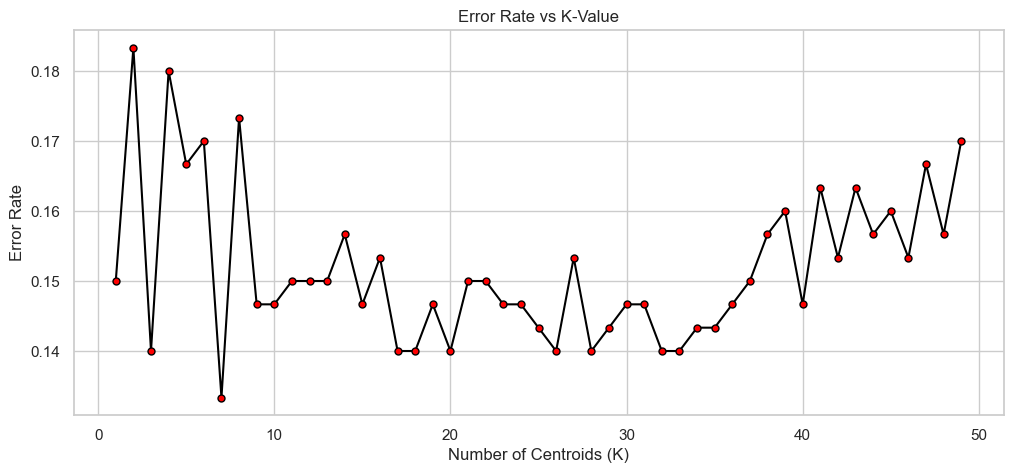

In [989]:
plt.figure(figsize=(12, 5))
plt.title('Error Rate vs K-Value')
plt.xlabel('Number of Centroids (K)')
plt.ylabel('Error Rate')

plt.plot(range(1, 50), error_rate, color='black', marker='o', markerfacecolor='red', markersize=5)

In [990]:
# extract k such that error is min
k = error_rate.index(min(error_rate))
print(f"min error occurs at {k} centroids")

min error occurs at 6 centroids


In [991]:
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[ 87  23]
 [ 28 162]]
              precision    recall  f1-score   support

           0       0.76      0.79      0.77       110
           1       0.88      0.85      0.86       190

    accuracy                           0.83       300
   macro avg       0.82      0.82      0.82       300
weighted avg       0.83      0.83      0.83       300



<a id="logistic-regression"></a> <br>
# Logistic Regression
[back to top](#table-of-contents)

Logistic regression is a supervised machine learning algorithm that accomplishes binary classification tasks by predicting the probability of an outcome, event, or observation.

It uses an underlying Sigmoid function which takes in any value and scales it to be an output between 0 and 1, then a cut-off point (usually at 0.5) is set to classify ambigous data.

In [992]:
# reduce size of dataframe for computational performance reasons
logreg_df = df.drop(['gpa_diff', 'field-xp relevance', 'visa sponsorship required'], axis=1)

In [993]:
X = logreg_df.drop(['accepted offer'], axis=1)
y = logreg_df['accepted offer']

In [994]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [995]:
logmodel = LogisticRegression(class_weight='balanced')

In [996]:
logmodel.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [997]:
predictions = logmodel.predict(X_test)

In [998]:
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[ 95  15]
 [ 17 173]]
              precision    recall  f1-score   support

           0       0.85      0.86      0.86       110
           1       0.92      0.91      0.92       190

    accuracy                           0.89       300
   macro avg       0.88      0.89      0.89       300
weighted avg       0.89      0.89      0.89       300



<a id="trees-and-forests"></a> <br>
# Decision Trees and Random Forests
[back to top](#table-of-contents)

A decision tree algorithm is a machine learning algorithm that uses a decision tree to make predictions. It follows a tree-like model of decisions and their possible consequences. The algorithm works by recursively splitting the data into subsets based on the most significant feature at each node of the tree. In these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels.

Random forest is a commonly-used machine learning algorithm that combines the output of multiple decision trees to reach a single result. Its ease of use and flexibility have fueled its adoption, as it handles both classification and regression problems. It is known as an 'ensemble learning method', which are made up of a set of classifiers — e.g. decision trees — and their predictions are aggregated to identify the most popular result.

<a id="decision-tree-classifier"></a> <br>
### Decision Tree Classifier

In [999]:
X = df.drop(['accepted offer'], axis=1)
y = df['accepted offer']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [1000]:
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [1001]:
predicitions = dtree.predict(X_test)
print(confusion_matrix(y_test, predictions))
print("\n")
print(classification_report(y_test, predictions))

[[ 95  15]
 [ 17 173]]


              precision    recall  f1-score   support

           0       0.85      0.86      0.86       110
           1       0.92      0.91      0.92       190

    accuracy                           0.89       300
   macro avg       0.88      0.89      0.89       300
weighted avg       0.89      0.89      0.89       300



<a id="decision-tree-visualization"></a> <br>
### Decision Tree Visualization

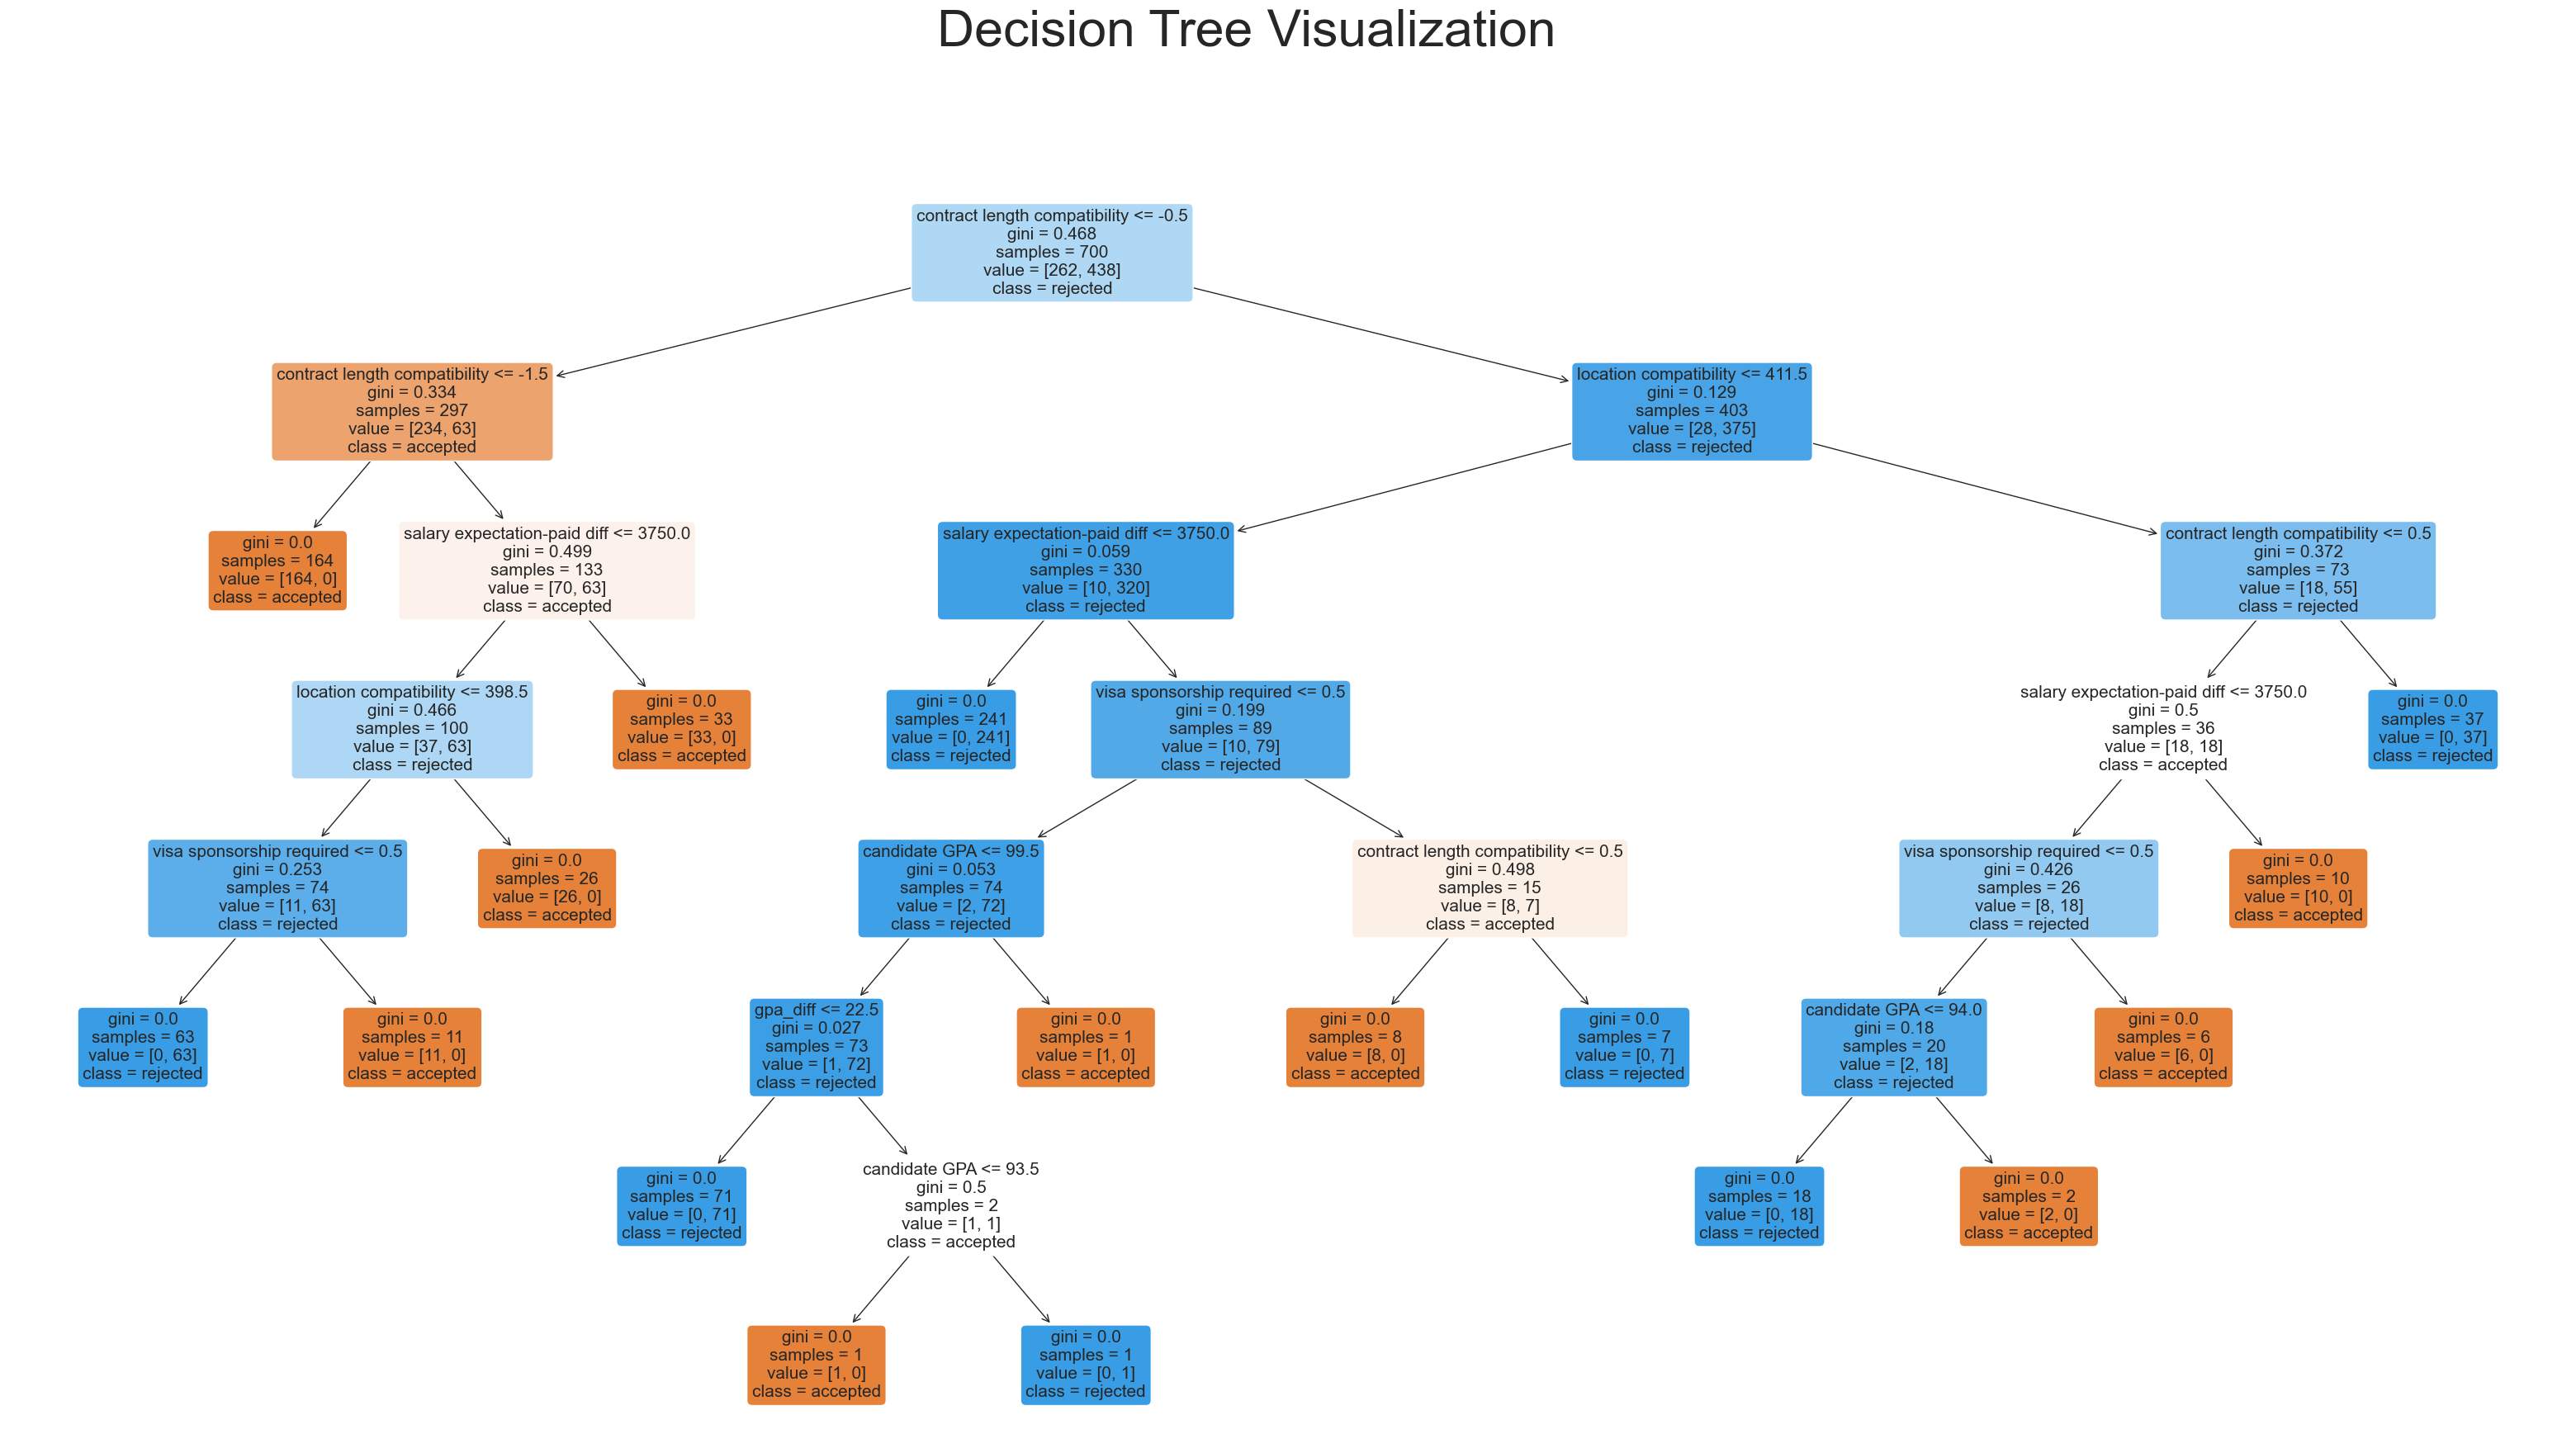

In [1002]:
# Display graphically how the DecisionTreeClassifer labels an offer as "likely to be accepted" or "likely to be rejected"
plt.figure(figsize=(40,20))
plot_tree(dtree, filled=True, feature_names=df.columns[:-1], class_names=['accepted', 'rejected'], rounded=True, fontsize=15)
plt.suptitle('Decision Tree Visualization', fontsize=45)
plt.show()

<a id="random-forest-classifier"></a> <br>
### Random Forest Classifier

In [1003]:
# instatiate a random forest classifier and train it using the previous dataframe
forest = RandomForestClassifier(n_estimators=200)
forest.fit(X_train, y_train)

# run predictions on the test data and evaluate its performance 
predicitions = dtree.predict(X_test)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[ 95  15]
 [ 17 173]]
              precision    recall  f1-score   support

           0       0.85      0.86      0.86       110
           1       0.92      0.91      0.92       190

    accuracy                           0.89       300
   macro avg       0.88      0.89      0.89       300
weighted avg       0.89      0.89      0.89       300



# Computing offers with Gale-Shapley and validating them using Classifier

In this conclusion section, I will compute a batch of offers using the above implementation of the Gale-Shapley algorithm and then use the SVM classifier previously trained to classify the offers computed as "likely to succeed" or "likely to fail". This demonstration aims to serve as a proof-of-concept for the automatic matchmaker at the core of this project.

In [1004]:
# populate compatibility matrix for the entire candidate and jobs dataframe
compatibility_matrix = compute_preference_matrix(candidates, jobs)

# keeps track of companies with job offers to still give out 
job_ids = compatibility_matrix.columns.tolist()

# keeps track of the offers made so far, candidate_id : (current_offer_company_id, [refusing_company_id1, ...])
offers = { candidate_id : [None, []] for candidate_id in range(len(candidates) + 1) }

# keeps track of the number of positions left per job
available_positions = [ jobs.loc[job_id, "Positions"] for job_id in range(len(jobs)) ]

# run the Gale-Shapley algorithm between the jobs and candidates dataset and extract the offers computed
computed_offers = gale_shapley(job_ids, offers, compatibility_matrix, available_positions)[0]

Populating the Compatibility matrix...
100%|██████████| 1000/1000 [00:38<00:00, 25.78it/s]
Executed populate_compatibility_matrix, Time Elapsed : 38.799 seconds
Population operation completed.
Executed gale_shapley, Time Elapsed : 3.499 seconds


In [1005]:
# extract all computed offers from the above run of the Gale-Shapley algorithm
computed_offers = {k: v[0] for k, v in computed_offers.items() if None not in v}

In [1006]:
offers_data = []

for candidate_id in computed_offers.keys():

    job_id = computed_offers[candidate_id]
    candidate_GPA = candidates.iloc[candidate_id]["Score"]
    
    compatibility = compatibility_matrix.iloc[candidate_id, job_id]
    
    job_min_GPA = jobs.iloc[job_id]["MinScore"]
    GPA_diff = candidate_GPA - job_min_GPA
    field_xp_relevance = 1 if jobs.iloc[job_id]["Field"] == candidates.iloc[candidate_id]["Experience"] else 0
    contract_length_compatibility = compute_contract_length_compatibility(candidate_id, job_id)
    location_compatibility = compute_location_compatibility(candidate_id, job_id)
    visa_required = compute_visa_requirements(candidateID, jobID)
    salary_diff = candidates.iloc[candidate_id]["Expected Salary"] - jobs.iloc[job_id]["Salary"]
    
    offers_data.append([
        candidate_id, job_id, candidate_GPA, job_min_GPA, field_xp_relevance,compatibility, GPA_diff, 
        contract_length_compatibility, location_compatibility, visa_required, salary_diff
    ])

In [1007]:
# constuct a dataframe to be fed to the classifier using the offers computed 
test_df = pd.DataFrame(offers_data, columns=[
    "candidate ID", "job ID", "candidate GPA", "job min GPA","compatibility",
    "gpa_diff", "field-xp relevance", "contract length compatibility", 
    "location compatibility", "visa sponsorship required", "salary expectation-paid diff"
])

test_df

,candidate ID,job ID,candidate GPA,job min GPA,compatibility,gpa_diff,field-xp relevance,contract length compatibility,location compatibility,visa sponsorship required,salary expectation-paid diff
0,3,35,82,90,0,0.78,-8,2.0,239,1,-5000.0
1,8,30,92,90,0,0.76,2,-3.0,202,0,2500.0
2,9,52,73,70,0,0.77,3,2.0,496,0,-2500.0
3,11,52,69,70,0,0.75,-1,0.0,418,0,-2500.0
4,24,64,80,80,0,0.76,0,0.0,120,0,-2500.0
...,...,...,...,...,...,...,...,...,...,...,...
256,986,43,92,90,0,0.76,2,0.0,412,0,-10000.0
257,989,96,66,70,0,0.75,-4,0.0,360,1,-2500.0
258,991,98,86,85,0,0.75,1,-2.0,102,0,-10000.0
259,992,5,78,80,0,0.77,-2,1.0,69,0,0.0


In [1008]:
# save candidate and job IDs in a separate dataframe
IDs = test_df[["candidate ID", "job ID"]]

# remove the candidate and job IDs from dataframe for classification purposes
test_df = test_df.drop(["candidate ID", "job ID"], axis=1)

In [1009]:
predictions = grid.predict(test_df)
predictions_col = [ "success" if prediction == 1 else "failure" for prediction in predictions ]

for i in range(len(predictions)):
    IDs.iloc[i]["Predicted offer outcome"] = "success" if predictions[i] == 1 else "failure"
    
IDs["Predicted offer outcome"] = pd.Series(predictions_col)

In [1010]:
display(HTML("<h1 class='display-5'>Offers computed by Gale-Shapley</h1>"))
 
# render offer using bootstrap alerts, where green indicates an offer "likely to succeed" and red "likely to fail"
for i in range(len(IDs)):
    
    candidate_name = candidates.iloc[IDs.iloc[i]["candidate ID"]]["Fullname"]
    job_title = jobs.iloc[IDs.iloc[i]["job ID"]]["Title"]
    job_company = jobs.iloc[IDs.iloc[i]["job ID"]]["Company"]
    offer_label = "success" if IDs.iloc[i]["Predicted offer outcome"] == "success" else "danger"
    
    display(HTML(
            f"<div class='alert alert-{offer_label}' style='width:900px;'><span class='badge text-bg-light'>Likely to {'succeed' if offer_label == 'success' else 'fail'}</span> {candidate_name} matched with {job_title} at {job_company}</div>" 
    ))  

<a id="project-conclusion"></a> <br>
# Project Conclusion
[back to top](#table-of-contents)

In conclusion, this project demonstrates that creating a system capable of assigning candidates to jobs according to their skills and suitability for the role is possible, however more validation needs to be carried out before such a system can be used in a real-world setting. 

The steps taken throughout this process were:

- Prepared the data by handling null values in the dataframe and conducted some analysis using Seaborn to spot any pattern or correlation within the data.
- Implemented a variant of the Gale-Shapley algorithm tailored to this project's needs and conducted some performance testing in regards to the algorithm's time performance and output quality.
- Identified a major bottleneck in the algorithm's performance caused by the matrix population procedure and explored three approaches to mitigate against this issue.
- Explored several machine learning models for the offer classification task
- Put everything discussed above together, and developed a pipeline which will take in a pool of candidates and jobs as input, compute an optimal arrangement using Gale-Shapley's algorithm and finally classify the offers using the Support Vector Machines model previously trained.

In the future, I aim to run this experiment on historical data rather than working with randomly generated one, as I believe it can provide greater insight into how the system would behave if it were to be deployed for real-life matchmaking tasks.

- As mentioned, validating the output of the algorithm appears to be the biggest challenge, since the criteria used to assess the output can be very volatile - i.e. if I were to manually match the two sets I would probably get a different arrangement than someone else, at which point deciding which arrangement is "correct" becomes difficult due to its subjective nature.
- In regard to the machine learning offer classifiers, proof of consistency has been achieved given that all approaches considered tend to yield an accuracy score between 88-92% however the challenge of validating their classification process is still something which will need to be addressed in the future.
- Finally, it would be nice to implement the version of Gale-Shapley's algorithm defined in the [**Improving the offers percentage**](#improving-offer-pecentage) section and assess its performance and behaviour against the current version.

I would like to thank the reader for reaching the end of this document, and encourage anyone to reach out through my LinkedIn profile for feedback or clarification on the project - Mattia.